# Predicting Genre and Year using Movie Plots
by Juan Ansaldo, Siya Adrekar

In this project, we utilize machine learning to analyze the [Wikipedia Movie Plots](https://www.kaggle.com/datasets/jrobischon/wikipedia-movie-plots) dataset, aiming to predict a movie's genre and release year from its plot summary. This endeavor bridges data science with cinematic storytelling, leveraging a dataset that spans a wide range of genres and a century's worth of films.

Our approach combines natural language processing and advanced machine learning techniques, employing TensorFlow and a Transformer-based model. Key to our methodology is preprocessing the data to address challenges like data imbalance and the diversity in genre classifications.

The project focuses on optimizing model performance through hyperparameter tuning and employing rigorous evaluation metrics. Our goal is to demonstrate the use of machine learning in the field of natural language processing, specifically within entertainment analytics, to provide insights into categorizing content and discerning historical trends in cinema.

### Imports and function definitions

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MultiLabelBinarizer
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_absolute_error, classification_report, multilabel_confusion_matrix
from sklearn.utils import resample

import tensorflow as tf
from tensorflow.keras import models, layers, Input, Model
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

import os
from IPython.core.display import display, HTML

In [ ]:
# Code citation
# Author: Dr. Glenn Bruns
# Source: Homework 9 - fruit-siamese.ipynb

# display options
pd.set_option('display.max_columns', 600)
pd.options.display.width = 120
pd.options.display.max_colwidth = 50
display(HTML("<style>.container { width:100% !important; }</style>"))

In [ ]:
# Code citation
# Author: Dr. Glenn Bruns
# Source: Homework 9 - fruit-siamese.ipynb

def plot_metric(history, metric='loss'):
    """ Plot training and test values for a metric. """

    val_metric = 'val_'+metric
    plt.plot(history.history[metric])
    plt.plot(history.history[val_metric])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'])
    plt.show();

In [ ]:
# Code Citation
# Author: Dr. Glenn Bruns
# Source: Transformers lecture slides
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([layers.Dense(dense_dim, activation="relu"),layers.Dense(embed_dim),])
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

This will help with making the results reproducible.

In [ ]:
np.random.seed(0)

### Read the wikipedia movie plots data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
file_path = '/content/drive/My Drive/wiki_movie_plots_deduped.csv'

Mounted at /content/drive


In [ ]:
df = pd.read_csv(file_path)

### Data exploration

To begin, we will explore the data set to get a better understanding of the data we will be using, as well as to inform our strategy for preprocessing and balancing the data set for machine learning.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34886 entries, 0 to 34885
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      34886 non-null  int64 
 1   Title             34886 non-null  object
 2   Origin/Ethnicity  34886 non-null  object
 3   Director          34886 non-null  object
 4   Cast              33464 non-null  object
 5   Genre             34886 non-null  object
 6   Wiki Page         34886 non-null  object
 7   Plot              34886 non-null  object
dtypes: int64(1), object(7)
memory usage: 2.1+ MB


The "Cast" column has missing values. Every column, except for "Release Year", contains object-type values, where the "Release Year" column consists of integer values.

In [ ]:
df.describe()

,Release Year
count,34886.000000
mean,1981.314252
std,27.815174
min,1901.000000
25%,1957.000000
50%,1988.000000
75%,2007.000000
max,2017.000000


Earliest movie release year: 1901 <br>
Latest movie release year: 2017

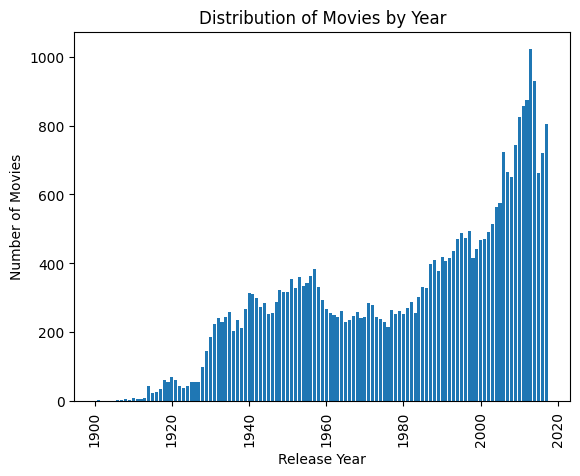

In [ ]:
years = df['Release Year'].value_counts()

plt.bar(years.index, years.values)
plt.title('Distribution of Movies by Year')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90);

In [ ]:
print(years)

2013    1021
2014     929
2012     874
2011     858
2010     825
        ... 
1906       3
1905       2
1903       2
1904       1
1902       1
Name: Release Year, Length: 117, dtype: int64


In this data set, the distribution of movies by release year spans from the years 1901 to 2017. The number of movies released has increased over time, with the highest number of movies released in a single year is 1021 in the year 2013. The significantly lower number of movies released prior to 1940 could pose challenges in adequately representing older films in the dataset.

In [ ]:
print(f"Number of unique genres: {df['Genre'].nunique()}")

Number of unique genres: 2265


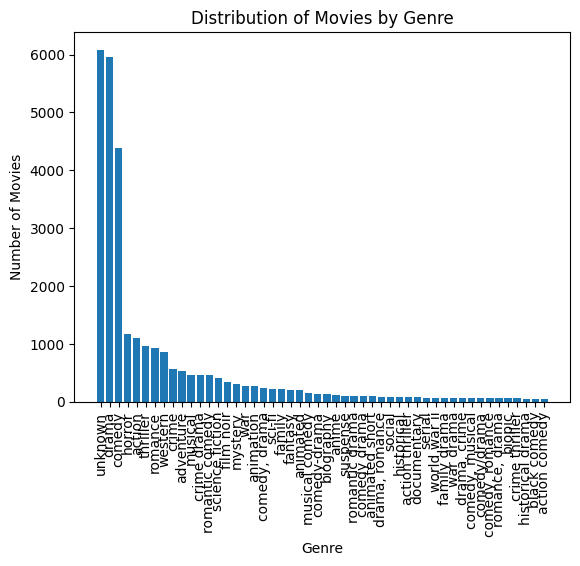

In [ ]:
genres = df['Genre'].value_counts().head(50)

plt.bar(genres.index, genres.values)
plt.title('Distribution of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90);

The most common movie genre in this data set is "unknown", followed closely by "drama". The distribution of movies by genre is heavily imbalanced, leading to low representation of genres in the data set. The number of unique genres in the data set is 2265.

In [ ]:
print(df['Genre'][2000])

comedy, musical


The 'Genre' column values appear to be formatted as a string and may include multiple genres, rather than being structured as a list.

In [ ]:
print(df['Plot'])

0        A bartender is working at a saloon, serving dr...
1        The moon, painted with a smiling face hangs ov...
2        The film, just over a minute long, is composed...
3        Lasting just 61 seconds and consisting of two ...
4        The earliest known adaptation of the classic f...
                               ...                        
34881    The film begins in 1919, just after World War ...
34882    Two musicians, Salih and Gürkan, described the...
34883    Zafer, a sailor living with his mother Döndü i...
34884    The film centres around a young woman named Am...
34885    The writer Orhan Şahin returns to İstanbul aft...
Name: Plot, Length: 34886, dtype: object


The "Plot" column values appear to have capital letters, punctuation, and special characters.

### Data preprocessing

After analyzing the dataset, we found that the distribution of movies by release year is heavily skewed. There is a notably low representation of movies released before 1940. Additionally, the data reveals that the most common movie genre is categorized as "unknown". Based on these insights, our strategy will involve retaining movies released after 1940 and excluding those with "unknown" genres.

In [ ]:
# Keep movies that were released after 1940
df2 = df[df['Release Year'] > 1940]

In [ ]:
# Drop movies with unknown genres
df2 = df2[df2['Genre'] != "unknown"]

Given the extensive range of 2265 unique genres currently stored as strings, our strategy involves combining similar genres to reduce redundancy. We will create lists of genres for each movie, recognizing that movies can span multiple genres. For instance, 'sci-fi' and 'science fiction' will be grouped under 'science fiction'. This reorganization into lists, with each containing up to 20 genres, simplifies our approach to addressing the problem.

In [ ]:
# Modified using ChatGPT
combined_genres = {
    'action': ['Action / Adventure'],
    'adventure': ['Action / Adventure'],
    'sci-fi': ['Science Fiction'],
    'science fiction': ['Science Fiction'],
    'comedy': ['Comedy'],
    'horror': ['Horror'],
    'thriller': ['Thriller / Suspense'],
    'suspense': ['Thriller / Suspense'],
    'romance': ['Romance'],
    'musical': ['Musical'],
    'fantasy': ['Fantasy'],
    'crime': ['Crime / Gangster'],
    'gangster': ['Crime / Gangster'],
    'war': ['War / Military'],
    'military': ['War / Military'],
    'mystery': ['Mystery / Detective'],
    'detective': ['Mystery / Detective'],
    'animation': ['Animation'],
    'animated': ['Animation'],
    'documentary': ['Documentary'],
    'biographical': ['Biographical'],
    'biopic': ['Biographical'],
    'historical': ['Historical / Period'],
    'period': ['Historical / Period'],
    'family': ['Family / Children'],
    'children': ['Family / Children'],
    'sports': ['Sports'],
    'western': ['Western'],
    'spy': ['Spy'],
    'espionage': ['Spy'],
    # Handling combined genres
    'action comedy': ['Action / Adventure', 'Comedy'],
    'romantic comedy': ['Romance', 'Comedy'],
    'crime drama': ['Crime / Gangster', 'Drama'],
    'action thriller': ['Action / Adventure', 'Thriller / Suspense'],
    'horror comedy': ['Horror', 'Comedy'],
    'science fiction comedy': ['Science Fiction', 'Comedy'],
    'musical comedy': ['Musical', 'Comedy'],
    # Default category for any other genre not listed above
    'default': ['Other']
}

In [ ]:
# Function to apply the combined genres (Modified by ChatGPT)
def simplify_genre(genre_string):
    genres = [genre.strip().lower() for genre in genre_string.split(',')]
    simplified_genres = []
    for genre in genres:
        simplified_genres.extend(combined_genres.get(genre, combined_genres['default']))
    return list(set(simplified_genres))  # Remove duplicates

In [ ]:
# Make a copy of the dataframe
df3 = df2.copy()

# Apply the 'simplify_genre' function to the copied dataframe
df3['Simplified Genre'] = df3['Genre'].apply(simplify_genre)

In [ ]:
# Drop movies with 'Other' genre (Generated by ChatGPT)
df3 = df3[~df3['Simplified Genre'].apply(lambda genres: "Other" in genres)]

In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14037 entries, 2983 to 34884
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Release Year      14037 non-null  int64 
 1   Title             14037 non-null  object
 2   Origin/Ethnicity  14037 non-null  object
 3   Director          14037 non-null  object
 4   Cast              13751 non-null  object
 5   Genre             14037 non-null  object
 6   Wiki Page         14037 non-null  object
 7   Plot              14037 non-null  object
 8   Simplified Genre  14037 non-null  object
dtypes: int64(1), object(8)
memory usage: 1.1+ MB


In [ ]:
# Explode the 'Simplified Genre' column to create a new row for each genre in each list (Generated by ChatGPT)
exploded_genres = df3['Simplified Genre'].explode()

In [ ]:
# Calculate the total number of unique genres
total_genres = exploded_genres.nunique()

# Display the total number of unique genres
print(f"Total number of unique genres: {total_genres}")

Total number of unique genres: 20


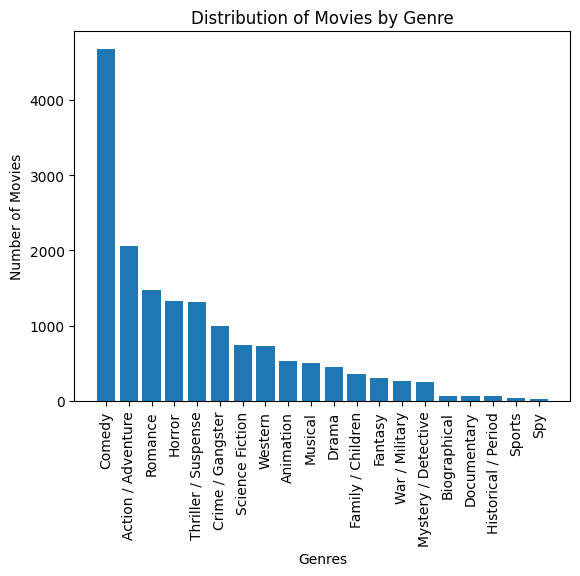

In [ ]:
genres = exploded_genres.value_counts()

plt.bar(genres.index, genres.values)
plt.title('Distribution of Movies by Genre')
plt.xlabel('Genres')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90);

In [ ]:
print(genres)

Comedy                 4678
Action / Adventure     2053
Romance                1480
Horror                 1331
Thriller / Suspense    1313
Crime / Gangster        997
Science Fiction         748
Western                 734
Animation               527
Musical                 510
Drama                   447
Family / Children       365
Fantasy                 303
War / Military          269
Mystery / Detective     250
Biographical             72
Documentary              71
Historical / Period      62
Sports                   33
Spy                      29
Name: Simplified Genre, dtype: int64


Given that movies may fall under multiple genres, we will produce multi-hot encodings for movie genres.

In [ ]:
# Modified using ChatGPT

# Initialize the MultiLabelBinarizer
mlb = MultiLabelBinarizer()

# Fit and transform the 'Simplified Genre' column
y_genre_encoded = mlb.fit_transform(df3['Simplified Genre'])

# Create a new DataFrame for the encoded genres
genre_encoded_df = pd.DataFrame(y_genre_encoded, columns=mlb.classes_)

# Concatenate the original DataFrame with the new encoded genres DataFrame
df4 = pd.concat([df3.reset_index(drop=True), genre_encoded_df.reset_index(drop=True)], axis=1)

In [ ]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14037 entries, 0 to 14036
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Release Year         14037 non-null  int64 
 1   Title                14037 non-null  object
 2   Origin/Ethnicity     14037 non-null  object
 3   Director             14037 non-null  object
 4   Cast                 13751 non-null  object
 5   Genre                14037 non-null  object
 6   Wiki Page            14037 non-null  object
 7   Plot                 14037 non-null  object
 8   Simplified Genre     14037 non-null  object
 9   Action / Adventure   14037 non-null  int64 
 10  Animation            14037 non-null  int64 
 11  Biographical         14037 non-null  int64 
 12  Comedy               14037 non-null  int64 
 13  Crime / Gangster     14037 non-null  int64 
 14  Documentary          14037 non-null  int64 
 15  Drama                14037 non-null  int64 
 16  Fami

After cleaning the genres, the distribution of movies by genre is still unbalanced. To address this, we will use the strategy of upsampling movies to match the number of movies that fall under the "Comedy" genre.

In [ ]:
# Modified using ChatGPT

# Flatten the 'Simplified Genre' column to create a new row for each genre in each list
exploded_df = df4.explode('Simplified Genre')

# Target number of samples per genre
target_count = exploded_df[exploded_df['Simplified Genre'] == 'Comedy'].shape[0]

# Initialize a DataFrame to hold the balanced dataset
balanced_df = pd.DataFrame()

# Loop over each unique genre
for genre in exploded_df['Simplified Genre'].unique():
    genre_df = exploded_df[exploded_df['Simplified Genre'] == genre]
    if genre_df.shape[0] <= target_count:
        # Upsample genres with fewer instances than the target count
        genre_df_balanced = resample(genre_df, replace=True, n_samples=target_count, random_state=0)

    balanced_df = pd.concat([balanced_df, genre_df_balanced])

In [ ]:
# Explode the 'Simplified Genre' column to create a new row for each genre in each list
exploded_genres = balanced_df.explode('Simplified Genre')

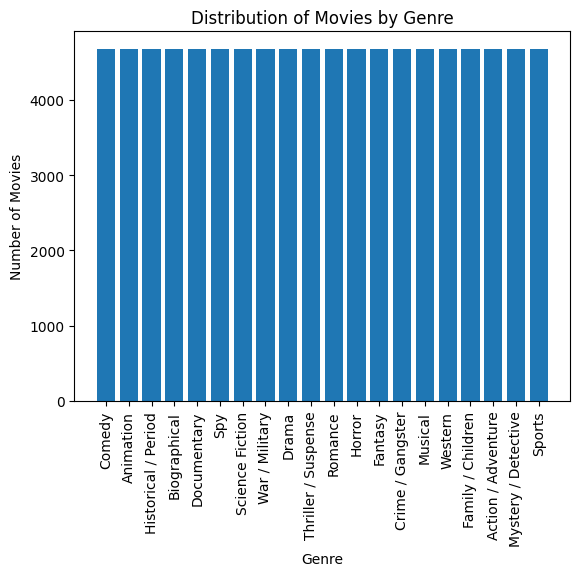

In [ ]:
# Count the occurrences of each genre
genres = exploded_genres['Simplified Genre'].value_counts()

plt.bar(genres.index, genres.values)
plt.xticks(rotation=90)
plt.title('Distribution of Movies by Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies');

In [ ]:
print(genres)

Comedy                 4678
Animation              4678
Historical / Period    4678
Biographical           4678
Documentary            4678
Spy                    4678
Science Fiction        4678
War / Military         4678
Drama                  4678
Thriller / Suspense    4678
Romance                4678
Horror                 4678
Fantasy                4678
Crime / Gangster       4678
Musical                4678
Western                4678
Family / Children      4678
Action / Adventure     4678
Mystery / Detective    4678
Sports                 4678
Name: Simplified Genre, dtype: int64


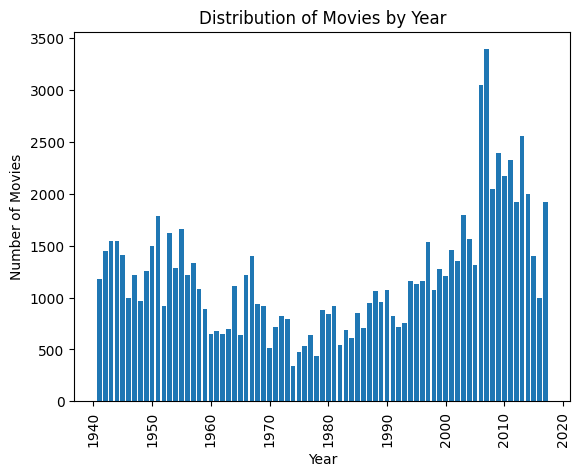

In [ ]:
years = balanced_df['Release Year'].value_counts()

plt.bar(years.index, years.values)
plt.title('Distribution of Movies by Year')
plt.xlabel('Year')
plt.ylabel('Number of Movies')
plt.xticks(rotation=90);

In [ ]:
balanced_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93560 entries, 8011 to 11234
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Release Year         93560 non-null  int64 
 1   Title                93560 non-null  object
 2   Origin/Ethnicity     93560 non-null  object
 3   Director             93560 non-null  object
 4   Cast                 90300 non-null  object
 5   Genre                93560 non-null  object
 6   Wiki Page            93560 non-null  object
 7   Plot                 93560 non-null  object
 8   Simplified Genre     93560 non-null  object
 9   Action / Adventure   93560 non-null  int64 
 10  Animation            93560 non-null  int64 
 11  Biographical         93560 non-null  int64 
 12  Comedy               93560 non-null  int64 
 13  Crime / Gangster     93560 non-null  int64 
 14  Documentary          93560 non-null  int64 
 15  Drama                93560 non-null  int64 
 16  F

In concluding the data preprocessing step, the data set now has equal representation of movie genres. The distribution of movies by release year appear to be more evenly distribution.

### Preprocessing for machine learning

We will now preprocess the dataset for machine learning. This involves using the train-test split technique to separate the data into training and testing sets. Since our project focuses on predicting both genre and release year, we will prepare two distinct target training sets, one for each task.

In [ ]:
X = balanced_df['Plot']
y_genre = balanced_df.iloc[:, 9:]  # Selecting all multi-hot-encoded genre columns
y_year = balanced_df['Release Year']

In [ ]:
# Split the data
X_train, X_test, y_train_genre, y_test_genre, y_train_year, y_test_year = train_test_split(
    X, y_genre, y_year, test_size=0.3, random_state=0)

In [ ]:
# Scale the year data (Modified using ChatGPT)
scaler = StandardScaler()
y_train_year = scaler.fit_transform(y_train_year.values.reshape(-1, 1)).flatten()
y_test_year = scaler.transform(y_test_year.values.reshape(-1, 1)).flatten()

In [ ]:
print(X_train.shape)
print(X_test.shape)

(65492,)
(28068,)


In [ ]:
print(y_train_genre.shape)
print(y_test_genre.shape)

(65492, 20)
(28068, 20)


In [ ]:
print(y_train_year.shape)
print(y_test_year.shape)

(65492,)
(28068,)


Since our data set is not large, we will import predefined GloVe embeddings to help capture sentiment in the movie plots to help increase model performance.

In [ ]:
# Import GloVe model for predefined embeddings
import gensim.downloader as api
glove_model = api.load("glove-wiki-gigaword-100")

In [ ]:
# Generated by ChatGPT
def get_glove_embeddings(texts, model):
    def get_vector(word):
        try:
            return model[word]
        except KeyError:
            return np.zeros(model.vector_size)

    embeddings = []
    for text in texts:
        words = text.split()
        word_vectors = [get_vector(word) for word in words]
        embeddings.append(np.mean(word_vectors, axis=0))
    return np.array(embeddings)

In [ ]:
# Convert text data to GloVe embeddings
X_train_vec = get_glove_embeddings(X_train, glove_model)
X_test_vec = get_glove_embeddings(X_test, glove_model)

In [ ]:
print(X_train_vec.shape)
print(X_test_vec.shape)

(65492, 100)
(28068, 100)


The dataset has been divided into training and testing sets, resulting in X_train and X_test sets, and others. Each of these sets contains 100 dimensions, corresponding to the embedding dimensions used in the GloVe model.

### Build a baseline model

We will now construct a baseline model, which was initially comprised of two separate models: one for classifying movie genres and another for predicting the release year of movies. These models are integrated to receive shared outputs from the transformer, enabling them to make respective predictions. Given that our dataset includes movies with multiple genres, we are addressing a multi-label classification problem. To effectively classify genres, we will employ the "sigmoid" activation function, and use "binary cross-entropy" as the loss function.

In [ ]:
dense_dim = 16
num_heads = 2
embedding_dim = glove_model.vector_size # GloVe embedding size is 100
num_classes = y_genre.shape[1]  # 20 genres

genre_neurons = 32
year_neurons = 64
act_fun = 'relu'

In [ ]:
# Combined two models using ChatGPT
def build_model():
    # Shared Base Model
    input_vec = Input(shape=(embedding_dim,))
    x = Lambda(lambda x: K.expand_dims(x, axis=1))(input_vec)
    x = TransformerEncoder(embedding_dim, dense_dim, num_heads)(x)
    shared_output = layers.GlobalAveragePooling1D()(x)

    # Genre Prediction Branch
    genre_branch = layers.Dense(genre_neurons, activation=act_fun)(shared_output)
    genre_output = layers.Dense(num_classes, activation='sigmoid', name='genre_output')(genre_branch)

    # Release Year Prediction Branch
    year_branch = layers.Dense(year_neurons, activation=act_fun)(shared_output)
    year_branch = layers.Dense(year_neurons, activation=act_fun)(year_branch)
    year_output = layers.Dense(1, activation='linear', name='year_output')(year_branch)

    # Combined Model
    model = Model(inputs=input_vec, outputs=[genre_output, year_output])
    return model

In [ ]:
# Delete old models
K.clear_session()

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1, 100)               0         ['input_1[0][0]']             
                                                                                                  
 transformer_encoder (Trans  (None, 1, 100)               84416     ['lambda[0][0]']              
 formerEncoder)                                                                                   
                                                                                                  
 global_average_pooling1d (  (None, 100)                  0         ['transformer_encoder[0][0

The baseline model is made up of 98,997 parameters, making it a small model.

In [ ]:
# Compile the model
model.compile(optimizer='adam',
              loss={'genre_output': 'binary_crossentropy',
                    'year_output': 'mean_absolute_error'},
              metrics={'genre_output': 'accuracy',
                       'year_output': 'mean_absolute_error'})


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=4, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=2, min_lr=0.000001, verbose=1)

In [ ]:
# Train the model
history = model.fit(X_train_vec, {'genre_output': y_train_genre, 'year_output': y_train_year},
                    epochs=50, batch_size=256, validation_split=0.3, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
180/180 [==============================] - 8s 11ms/step - loss: 1.0778 - genre_output_loss: 0.2740 - year_output_loss: 0.8038 - genre_output_accuracy: 0.0978 - year_output_mean_absolute_error: 0.8038 - val_loss: 0.9305 - val_genre_output_loss: 0.2301 - val_year_output_loss: 0.7004 - val_genre_output_accuracy: 0.1397 - val_year_output_mean_absolute_error: 0.7004 - lr: 0.0010
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.9027 - genre_output_loss: 0.2171 - year_output_loss: 0.6855 - genre_output_accuracy: 0.2021 - year_output_mean_absolute_error: 0.6855 - val_loss: 0.8884 - val_genre_output_loss: 0.1989 - val_year_output_loss: 0.6895 - val_genre_output_accuracy: 0.3093 - val_year_output_mean_absolute_error: 0.6895 - lr: 0.0010
Epoch 3/50
180/180 [==============================] - 2s 9ms/step - loss: 0.8122 - genre_output_loss: 0.1832 - year_output_loss: 0.6290 - genre_output_accuracy: 0.3400 - year_output_mean_absolute_error: 0.6290 - val_loss: 0.8

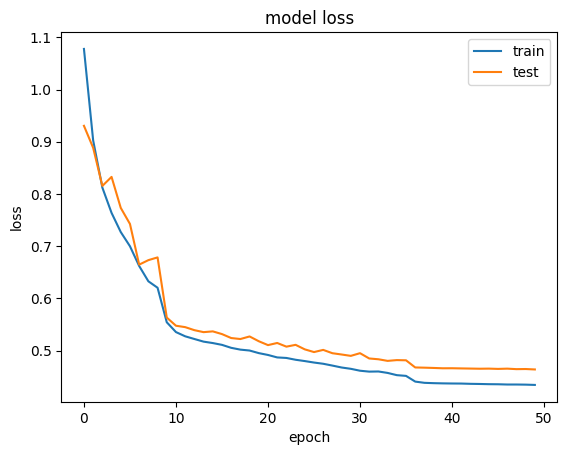

In [ ]:
plot_metric(history)

In [ ]:
# Evaluate the model
results = model.evaluate(X_test_vec, {'genre_output': y_test_genre, 'year_output': y_test_year})

print(f"'Genre' Prediction Accuracy: {np.round(results[3], 3)}")
print(f"'Release Year' Mean Absolute Error: {np.round(results[4], 3)}")

878/878 [==============================] - 3s 4ms/step - loss: 0.4681 - genre_output_loss: 0.1273 - year_output_loss: 0.3408 - genre_output_accuracy: 0.5366 - year_output_mean_absolute_error: 0.3408
'Genre' Prediction Accuracy: 0.537
'Release Year' Mean Absolute Error: 0.341


The graph indicates an initial sharp decrease in loss values for both the training and test datasets, which then stabilizes after approximately 10 epochs. Following this, both training and test losses continue to decrease gradually over time. With the implementation of early stopping and reducing the learning rate on a plateau, the model was able to complete the full 50 epochs. Consequently, our baseline model achieves a genre prediction accuracy of 53.7 % and a release year mean squared error of 0.341.

### Hyperparameter tuning

After building a baseline model, we can see the model needs to be tuned to perform better. The approach we will take is performing small-scale grid searches to find the best hyperparameters for this model that will work best for our problem.

#### Code from HW for hyperparameter tuning

In [ ]:
def scores_to_dataframe(scores):
    """ Return hyperparameters and scores in a data frame. """

    params_list, acc_list = scores

    params = pd.DataFrame(params_list)
    accs = pd.Series(acc_list)
    scores_df = pd.concat([params, accs], axis=1)

    return scores_df

In [ ]:
# Modified by ChatGPT
def get_model(num_heads=2, dense_dim=32, genre_neurons=[32], year_neurons=[32], act_fun='relu', initializer='glorot_uniform',
              regularizer=None, dropout=False, drop_rate=0.5, batch_norm=False):
    # Shared Base Model
    embedding_dim = glove_model.vector_size
    input_vec = Input(shape=(embedding_dim,))
    x = layers.Lambda(lambda x: K.expand_dims(x, axis=1))(input_vec)
    x = TransformerEncoder(embedding_dim, dense_dim, num_heads)(x)
    shared_output = layers.GlobalAveragePooling1D()(x)

    # Genre Prediction Branch
    genre_branch = shared_output
    num_classes = y_genre_encoded.shape[1]

    for neurons in genre_neurons:
        if dropout:
            genre_branch = layers.Dropout(drop_rate)(genre_branch)

        genre_branch = layers.Dense(neurons, kernel_initializer=initializer, kernel_regularizer=regularizer)(genre_branch)

        if batch_norm:
            genre_branch = layers.BatchNormalization()(genre_branch)

        genre_branch = layers.Activation(act_fun)(genre_branch)

    if dropout:
        genre_branch = layers.Dropout(drop_rate)(genre_branch)

    genre_output = layers.Dense(num_classes, activation='sigmoid', name='genre_output')(genre_branch)

    # Release Year Prediction Branch
    year_branch = shared_output

    for neurons in year_neurons:
        if dropout:
            year_branch = layers.Dropout(drop_rate)(year_branch)

        year_branch = layers.Dense(neurons, kernel_initializer=initializer, kernel_regularizer=regularizer)(year_branch)

        if batch_norm:
            year_branch = layers.BatchNormalization()(year_branch)

        year_branch = layers.Activation(act_fun)(year_branch)

    if dropout:
        year_branch = layers.Dropout(drop_rate)(year_branch)

    year_output = layers.Dense(1, activation='linear', name='year_output')(year_branch)

    # Combined Model
    model = Model(inputs=input_vec, outputs=[genre_output, year_output])
    return model

In [ ]:
default_params = {
    'num_heads': 8,
    'dense_dim': 64,
    'genre_neurons': [128],
    'year_neurons': [512],
    'act_fun': 'relu',
    'initializer': 'glorot_uniform',
    'regularizer': None,
    'optimizer': 'adam',
    'dropout': False,
    'drop_rate': 0.5,
    'batch_norm': False
}

In [ ]:
def evaluate_params(params, verbose=1):
    K.clear_session()  # delete old models

    pars = default_params.copy()
    pars.update(params)

    # Extract parameters
    num_heads = pars['num_heads']
    dense_dim = pars['dense_dim']
    genre_neurons = pars['genre_neurons']
    year_neurons = pars['year_neurons']
    act_fun = pars['act_fun']
    initializer = pars['initializer']
    regularizer = pars['regularizer']
    optimizer = pars['optimizer']
    dropout = pars['dropout']
    drop_rate = pars['drop_rate']
    batch_norm = pars['batch_norm']

    # Callbacks
    early_stopping = tf.keras.callbacks.EarlyStopping(patience=2, restore_best_weights=True)

    # Build the model
    model = get_model(num_heads=num_heads, dense_dim=dense_dim, genre_neurons=genre_neurons, year_neurons=year_neurons,
                      act_fun=act_fun, dropout=dropout, drop_rate=drop_rate, batch_norm=batch_norm)

    # Compile the model
    model.compile(optimizer=optimizer,
                  loss={'genre_output': 'binary_crossentropy',
                        'year_output': 'mean_absolute_error'},
                  metrics={'genre_output': 'accuracy',
                           'year_output': 'mean_absolute_error'})

    # Train the model
    history = model.fit(X_train_vec, {'genre_output': y_train_genre, 'year_output': y_train_year},
                        epochs=50, batch_size=256, validation_split=0.3, callbacks=[early_stopping])

    # Extracting the mean validation accuracy for genre and mean squared error for year
    genre_mean_acc = np.mean(history.history['val_genre_output_accuracy'][-2:])
    year_mean_mse = np.mean(history.history['val_year_output_mean_absolute_error'][-2:])

    return pars, (genre_mean_acc, year_mean_mse), history

In [ ]:
def grid_search(param_grid, verbose=1):

    params_list = []
    acc_list = []
    for params in ParameterGrid(param_grid):
        print(f"params: {params}")
        pars, acc, history = evaluate_params(params, verbose=verbose)

        params_list.append(pars)
        acc_list.append(acc)

    return params_list, acc_list

#### Declaring activation functions, weight regularizers, and optimizers

In [ ]:
# activation functions
leakyRelu = layers.LeakyReLU(alpha=0.3)

# weight regularizers
l1 = tf.keras.regularizers.l1(0.001)
l2 = tf.keras.regularizers.l2(0.001)

# optimizers
momentum = tf.keras.optimizers.legacy.SGD(momentum=0.9)
nesterov = tf.keras.optimizers.legacy.SGD(momentum=0.9, nesterov=True)

#### Grid searches for the best hyperparameters

##### Grid search for best number of attention heads and neurons for the Transformer

In [ ]:
param_grid = {
    'num_heads': [1,2,4,8],
    'dense_dim': [16,32,64,128,256],
    'genre_neurons': [[32]],
    'year_neurons': [[64]],
}

results = grid_search(param_grid)

params: {'dense_dim': 2048, 'genre_neurons': [32], 'num_heads': 1, 'year_neurons': [64]}
Epoch 1/50
180/180 [==============================] - 5s 10ms/step - loss: 1.0707 - genre_output_loss: 0.2536 - year_output_loss: 0.8171 - genre_output_accuracy: 0.0704 - year_output_mean_absolute_error: 0.8171 - val_loss: 0.9000 - val_genre_output_loss: 0.1929 - val_year_output_loss: 0.7071 - val_genre_output_accuracy: 0.1183 - val_year_output_mean_absolute_error: 0.7071
Epoch 2/50
180/180 [==============================] - 1s 8ms/step - loss: 0.8539 - genre_output_loss: 0.1814 - year_output_loss: 0.6725 - genre_output_accuracy: 0.2135 - year_output_mean_absolute_error: 0.6725 - val_loss: 0.7751 - val_genre_output_loss: 0.1636 - val_year_output_loss: 0.6115 - val_genre_output_accuracy: 0.3190 - val_year_output_mean_absolute_error: 0.6115
Epoch 3/50
180/180 [==============================] - 1s 8ms/step - loss: 0.7314 - genre_output_loss: 0.1509 - year_output_loss: 0.5806 - genre_output_accuracy: 0

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,1,2048,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.8306697905063629, 0.1489778384566307)"
1,2,2048,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.6293261349201202, 0.3294495493173599)"
2,4,2048,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.6199104189872742, 0.36994345486164093)"
3,8,2048,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.5562143623828888, 0.4380769282579422)"
4,1,4096,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.6867365539073944, 0.306342750787735)"
5,2,4096,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.5769543945789337, 0.4205923527479172)"
6,4,4096,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7142966091632843, 0.28038790822029114)"
7,8,4096,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7065859138965607, 0.25852903723716736)"
8,1,8192,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7623676657676697, 0.19105688482522964)"
9,2,8192,[32],[64],relu,glorot_uniform,None,adam,False,0.5,False,"(0.4835606813430786, 0.5565482676029205)"


##### Grid search for the best number of neurons for the genre model and the year model

In [ ]:
param_grid = {
    'num_heads': [4],
    'dense_dim': [32],
    'genre_neurons': [[256],[512],[1024],[2048],[4096]],
    'year_neurons': [[256],[512],[1024],[2048]],
}

results = grid_search(param_grid)

params: {'dense_dim': 2048, 'genre_neurons': [128], 'num_heads': 2, 'year_neurons': [256]}
Epoch 1/50
180/180 [==============================] - 5s 10ms/step - loss: 1.0356 - genre_output_loss: 0.2081 - year_output_loss: 0.8275 - genre_output_accuracy: 0.1052 - year_output_mean_absolute_error: 0.8275 - val_loss: 0.9674 - val_genre_output_loss: 0.1874 - val_year_output_loss: 0.7800 - val_genre_output_accuracy: 0.1640 - val_year_output_mean_absolute_error: 0.7800
Epoch 2/50
180/180 [==============================] - 1s 8ms/step - loss: 0.8171 - genre_output_loss: 0.1619 - year_output_loss: 0.6552 - genre_output_accuracy: 0.3089 - year_output_mean_absolute_error: 0.6552 - val_loss: 1.1109 - val_genre_output_loss: 0.1621 - val_year_output_loss: 0.9489 - val_genre_output_accuracy: 0.2803 - val_year_output_mean_absolute_error: 0.9489
Epoch 3/50
180/180 [==============================] - 2s 8ms/step - loss: 0.6958 - genre_output_loss: 0.1315 - year_output_loss: 0.5643 - genre_output_accuracy:

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,2,2048,[128],[256],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7313975989818573, 0.24767757207155228)"
1,2,2048,[128],[512],relu,glorot_uniform,None,adam,False,0.5,False,"(0.6253053843975067, 0.4319314509630203)"
2,2,2048,[128],[1024],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7049572467803955, 0.2674205005168915)"
3,2,2048,[128],[2048],relu,glorot_uniform,None,adam,False,0.5,False,"(0.5612021684646606, 0.5052289813756943)"
4,2,2048,[128],[4096],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7378613650798798, 0.2637624591588974)"
5,2,2048,[256],[256],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7127697467803955, 0.2978578060865402)"
6,2,2048,[256],[512],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7156198918819427, 0.267929270863533)"
7,2,2048,[256],[1024],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7680679857730865, 0.24467547982931137)"
8,2,2048,[256],[2048],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7148819267749786, 0.27732811868190765)"
9,2,2048,[256],[4096],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7021834254264832, 0.28274330496788025)"


##### Grid search for the best combination of stacked dense layers for the genre model and the year model

In [ ]:
param_grid = {
    'num_heads': [4],
    'dense_dim': [32],
    'genre_neurons': [[2048],[2048,2048],[2048,2048,2048],[2048,2048,2048,2048]],
    'year_neurons': [[1024],[1024,1024],[1024,1024,1024],[1024,1024,1024,1024]]
}

results = grid_search(param_grid)

params: {'dense_dim': 2048, 'genre_neurons': [512], 'num_heads': 2, 'year_neurons': [256]}
Epoch 1/50
180/180 [==============================] - 5s 11ms/step - loss: 1.0038 - genre_output_loss: 0.2009 - year_output_loss: 0.8029 - genre_output_accuracy: 0.1410 - year_output_mean_absolute_error: 0.8029 - val_loss: 0.8793 - val_genre_output_loss: 0.1702 - val_year_output_loss: 0.7092 - val_genre_output_accuracy: 0.2775 - val_year_output_mean_absolute_error: 0.7092
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.7927 - genre_output_loss: 0.1461 - year_output_loss: 0.6467 - genre_output_accuracy: 0.3837 - year_output_mean_absolute_error: 0.6467 - val_loss: 0.8603 - val_genre_output_loss: 0.1349 - val_year_output_loss: 0.7253 - val_genre_output_accuracy: 0.4125 - val_year_output_mean_absolute_error: 0.7253
Epoch 3/50
180/180 [==============================] - 2s 8ms/step - loss: 0.6793 - genre_output_loss: 0.1242 - year_output_loss: 0.5551 - genre_output_accuracy:

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,2,2048,[512],[256],relu,glorot_uniform,None,adam,False,0.5,False,"(0.703710287809372, 0.35337188839912415)"
1,2,2048,[512],"[256, 256]",relu,glorot_uniform,None,adam,False,0.5,False,"(0.8220683932304382, 0.16884172707796097)"
2,2,2048,[512],"[256, 256, 256]",relu,glorot_uniform,None,adam,False,0.5,False,"(0.8339016735553741, 0.16391532868146896)"
3,2,2048,[512],"[256, 256, 256, 256]",relu,glorot_uniform,None,adam,False,0.5,False,"(0.6745724678039551, 0.3341049700975418)"
4,2,2048,"[512, 512]",[256],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7967986762523651, 0.24655389785766602)"
5,2,2048,"[512, 512]","[256, 256]",relu,glorot_uniform,None,adam,False,0.5,False,"(0.7932614088058472, 0.2501978129148483)"
6,2,2048,"[512, 512]","[256, 256, 256]",relu,glorot_uniform,None,adam,False,0.5,False,"(0.8190909922122955, 0.1994883343577385)"
7,2,2048,"[512, 512]","[256, 256, 256, 256]",relu,glorot_uniform,None,adam,False,0.5,False,"(0.8412815630435944, 0.1637059524655342)"
8,2,2048,"[512, 512, 512]",[256],relu,glorot_uniform,None,adam,False,0.5,False,"(0.854845255613327, 0.18957260251045227)"
9,2,2048,"[512, 512, 512]","[256, 256]",relu,glorot_uniform,None,adam,False,0.5,False,"(0.8470836877822876, 0.20046401768922806)"


##### Grid search for the best initializer and regularizer combination

In [ ]:
param_grid = {
    'num_heads': [4],
    'dense_dim': [32],
    'genre_neurons': [[2048,2048]],
    'year_neurons': [[1024,1024,1024]],
    'initializer': ['glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform'],
    'regularizer': [None, l1, l2]
}

results = grid_search(param_grid)

params: {'dense_dim': 2048, 'genre_neurons': [512, 512, 512], 'initializer': 'glorot_normal', 'num_heads': 2, 'regularizer': None, 'year_neurons': [256]}
Epoch 1/50
180/180 [==============================] - 6s 11ms/step - loss: 1.0321 - genre_output_loss: 0.1957 - year_output_loss: 0.8364 - genre_output_accuracy: 0.1267 - year_output_mean_absolute_error: 0.8364 - val_loss: 1.1840 - val_genre_output_loss: 0.1677 - val_year_output_loss: 1.0163 - val_genre_output_accuracy: 0.2454 - val_year_output_mean_absolute_error: 1.0163
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.7976 - genre_output_loss: 0.1391 - year_output_loss: 0.6586 - genre_output_accuracy: 0.3911 - year_output_mean_absolute_error: 0.6586 - val_loss: 0.7104 - val_genre_output_loss: 0.1352 - val_year_output_loss: 0.5752 - val_genre_output_accuracy: 0.3938 - val_year_output_mean_absolute_error: 0.5752
Epoch 3/50
180/180 [==============================] - 2s 9ms/step - loss: 0.6529 - genre_output_l

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,2,2048,"[512, 512, 512]",[256],relu,glorot_normal,None,adam,False,0.5,False,"(0.8250967264175415, 0.22957743704319)"
1,2,2048,"[512, 512, 512]",[256],relu,glorot_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.7734375, 0.29919223487377167)"
2,2,2048,"[512, 512, 512]",[256],relu,glorot_normal,<keras.src.regularizers.L2 object at 0x7ca1e06...,adam,False,0.5,False,"(0.7298961877822876, 0.3751150220632553)"
3,2,2048,"[512, 512, 512]",[256],relu,glorot_uniform,None,adam,False,0.5,False,"(0.7902076542377472, 0.28805379569530487)"
4,2,2048,"[512, 512, 512]",[256],relu,glorot_uniform,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.7448595464229584, 0.3290056437253952)"
5,2,2048,"[512, 512, 512]",[256],relu,glorot_uniform,<keras.src.regularizers.L2 object at 0x7ca1e06...,adam,False,0.5,False,"(0.8414851427078247, 0.2260444536805153)"
6,2,2048,"[512, 512, 512]",[256],relu,he_normal,None,adam,False,0.5,False,"(0.8023462891578674, 0.3259838744997978)"
7,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.8425030708312988, 0.1979554295539856)"
8,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L2 object at 0x7ca1e06...,adam,False,0.5,False,"(0.7879682183265686, 0.2721557542681694)"
9,2,2048,"[512, 512, 512]",[256],relu,he_uniform,None,adam,False,0.5,False,"(0.7679153084754944, 0.31031885743141174)"


##### Grid search for the best activation function

In [ ]:
param_grid = {
    'num_heads': [4],
    'dense_dim': [32],
    'genre_neurons': [[2048,2048]],
    'year_neurons': [[1024,1024,1024]],
    'initializer': ['he_normal'],
    'regularizer': [None],
    'act_fun': ['relu', 'elu', 'selu', 'tanh', leakyRelu]
}

results = grid_search(param_grid)

params: {'act_fun': 'relu', 'dense_dim': 2048, 'genre_neurons': [512, 512, 512], 'initializer': 'he_normal', 'num_heads': 2, 'regularizer': <keras.src.regularizers.L1 object at 0x7ca1e0669ae0>, 'year_neurons': [256]}
Epoch 1/50
180/180 [==============================] - 5s 12ms/step - loss: 1.0259 - genre_output_loss: 0.1987 - year_output_loss: 0.8272 - genre_output_accuracy: 0.1169 - year_output_mean_absolute_error: 0.8272 - val_loss: 1.0195 - val_genre_output_loss: 0.1654 - val_year_output_loss: 0.8541 - val_genre_output_accuracy: 0.2652 - val_year_output_mean_absolute_error: 0.8541
Epoch 2/50
180/180 [==============================] - 2s 10ms/step - loss: 0.7979 - genre_output_loss: 0.1424 - year_output_loss: 0.6556 - genre_output_accuracy: 0.3722 - year_output_mean_absolute_error: 0.6556 - val_loss: 0.9413 - val_genre_output_loss: 0.1323 - val_year_output_loss: 0.8090 - val_genre_output_accuracy: 0.4190 - val_year_output_mean_absolute_error: 0.8090
Epoch 3/50
180/180 [=============

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.8301608264446259, 0.20547697693109512)"
1,2,2048,"[512, 512, 512]",[256],elu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.8097007274627686, 0.22942397743463516)"
2,2,2048,"[512, 512, 512]",[256],selu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.7419584691524506, 0.296354740858078)"
3,2,2048,"[512, 512, 512]",[256],tanh,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.7178084254264832, 0.3563002049922943)"
4,2,2048,"[512, 512, 512]",[256],<keras.src.layers.activation.leaky_relu.LeakyR...,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.8184038996696472, 0.1955043151974678)"


##### Grid search for the best optimizer

In [ ]:
param_grid = {
    'num_heads': [4],
    'dense_dim': [32],
    'genre_neurons': [[2048,2048]],
    'year_neurons': [[1024,1024,1024]],
    'initializer': ['he_normal'],
    'regularizer': [None],
    'act_fun': ['relu'],
    'optimizer': ['adam', 'nadam', 'rmsprop', 'SGD', momentum, nesterov]
}

results = grid_search(param_grid)

params: {'act_fun': 'relu', 'dense_dim': 2048, 'genre_neurons': [512, 512, 512], 'initializer': 'he_normal', 'num_heads': 2, 'optimizer': 'adam', 'regularizer': <keras.src.regularizers.L1 object at 0x7ca1e0669ae0>, 'year_neurons': [256]}
Epoch 1/50
180/180 [==============================] - 6s 11ms/step - loss: 0.9952 - genre_output_loss: 0.1927 - year_output_loss: 0.8024 - genre_output_accuracy: 0.1400 - year_output_mean_absolute_error: 0.8024 - val_loss: 0.8340 - val_genre_output_loss: 0.1537 - val_year_output_loss: 0.6803 - val_genre_output_accuracy: 0.3243 - val_year_output_mean_absolute_error: 0.6803
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 0.7424 - genre_output_loss: 0.1320 - year_output_loss: 0.6104 - genre_output_accuracy: 0.4294 - year_output_mean_absolute_error: 0.6104 - val_loss: 0.6385 - val_genre_output_loss: 0.1144 - val_year_output_loss: 0.5241 - val_genre_output_accuracy: 0.5054 - val_year_output_mean_absolute_error: 0.5241
Epoch 3/50
18

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.8141032159328461, 0.27227434515953064)"
1,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,nadam,False,0.5,False,"(0.6504224538803101, 0.4560338407754898)"
2,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,rmsprop,False,0.5,False,"(0.4356677532196045, 0.7545895576477051)"
3,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,SGD,False,0.5,False,"(0.12512723729014397, 1.1068377792835236)"
4,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,<keras.src.optimizers.legacy.gradient_descent....,False,0.5,False,"(0.22780944406986237, 0.8210467100143433)"
5,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,<keras.src.optimizers.legacy.gradient_descent....,False,0.5,False,"(0.3769086003303528, 0.6257935166358948)"


##### Grid search using batch normalization

In [ ]:
param_grid = {
    'num_heads': [4],
    'dense_dim': [32],
    'genre_neurons': [[2048,2048]],
    'year_neurons': [[1024,1024,1024]],
    'initializer': ['he_normal'],
    'regularizer': [None],
    'act_fun': ['relu'],
    'optimizer': ['nadam'],
    'batch_norm': [True, False]
}

results = grid_search(param_grid)

params: {'act_fun': 'relu', 'batch_norm': True, 'dense_dim': 2048, 'genre_neurons': [512, 512, 512], 'initializer': 'he_normal', 'num_heads': 2, 'optimizer': 'adam', 'regularizer': <keras.src.regularizers.L1 object at 0x7ca1e0669ae0>, 'year_neurons': [256]}
Epoch 1/50
180/180 [==============================] - 7s 13ms/step - loss: 0.7089 - genre_output_loss: 0.1183 - year_output_loss: 0.5906 - genre_output_accuracy: 0.5937 - year_output_mean_absolute_error: 0.5906 - val_loss: 0.9593 - val_genre_output_loss: 0.1935 - val_year_output_loss: 0.7658 - val_genre_output_accuracy: 0.1207 - val_year_output_mean_absolute_error: 0.7658
Epoch 2/50
180/180 [==============================] - 2s 11ms/step - loss: 0.5521 - genre_output_loss: 0.0686 - year_output_loss: 0.4835 - genre_output_accuracy: 0.7335 - year_output_mean_absolute_error: 0.4835 - val_loss: 1.6767 - val_genre_output_loss: 0.2023 - val_year_output_loss: 1.4745 - val_genre_output_accuracy: 0.2288 - val_year_output_mean_absolute_error:

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,True,"(0.22786034643650055, 1.4057985544204712)"
1,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.8270816504955292, 0.22242138534784317)"


##### Grid search using dropout

In [ ]:
param_grid = {
    'num_heads': [4],
    'dense_dim': [32],
    'genre_neurons': [[2048,2048]],
    'year_neurons': [[1024,1024,1024]],
    'initializer': ['he_normal'],
    'regularizer': [None],
    'act_fun': ['relu'],
    'optimizer': ['nadam'],
    'batch_norm': [False],
    'dropout': [True, False]
}

results = grid_search(param_grid)

params: {'act_fun': 'relu', 'batch_norm': False, 'dense_dim': 2048, 'dropout': True, 'genre_neurons': [512, 512, 512], 'initializer': 'he_normal', 'num_heads': 2, 'optimizer': 'adam', 'regularizer': <keras.src.regularizers.L1 object at 0x7ca1e0669ae0>, 'year_neurons': [256]}
Epoch 1/50
180/180 [==============================] - 6s 11ms/step - loss: 1.1649 - genre_output_loss: 0.2180 - year_output_loss: 0.9469 - genre_output_accuracy: 0.0506 - year_output_mean_absolute_error: 0.9469 - val_loss: 1.2312 - val_genre_output_loss: 0.3432 - val_year_output_loss: 0.8879 - val_genre_output_accuracy: 0.0437 - val_year_output_mean_absolute_error: 0.8879
Epoch 2/50
180/180 [==============================] - 2s 9ms/step - loss: 1.0182 - genre_output_loss: 0.2029 - year_output_loss: 0.8153 - genre_output_accuracy: 0.0702 - year_output_mean_absolute_error: 0.8153 - val_loss: 1.0205 - val_genre_output_loss: 0.2755 - val_year_output_loss: 0.7450 - val_genre_output_accuracy: 0.1044 - val_year_output_mea

In [ ]:
scores_to_dataframe(results)

,num_heads,dense_dim,genre_neurons,year_neurons,act_fun,initializer,regularizer,optimizer,dropout,drop_rate,batch_norm,0
0,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,True,0.5,False,"(0.6061685681343079, 0.3451176881790161)"
1,2,2048,"[512, 512, 512]",[256],relu,he_normal,<keras.src.regularizers.L1 object at 0x7ca1e06...,adam,False,0.5,False,"(0.6866347789764404, 0.5022469758987427)"


#### Findings from hyperparameter tuning

Following small-scale grid searches, we determined the optimal hyperparameters: the transformer layer will have 4 attention heads and 32 dense dimensions. The genre model branch will consist of two stacked fully-connected layers, each with 2048 neurons, while the year model branch will have three stacked fully-connected layers with 1024 neurons each. We will use the 'He normal' initializer, no regularizer, the 'ReLU' activation function, and the 'Nadam' optimizer.

### Final model

Following our small-scale grid search, we have successfully established a final model for our analysis.

In [ ]:
dense_dim = 32
num_heads = 4
embedding_dim = glove_model.vector_size # GloVe embedding size is 100
num_classes = y_genre.shape[1] # 20 classes

genre_neurons = 2048
year_neurons = 1024
act_fun = 'relu'
initializer = 'he_normal'

In [ ]:
# Combined two models using ChatGPT
def build_model():
    # Shared Base Model
    input_vec = Input(shape=(embedding_dim,))
    x = Lambda(lambda x: K.expand_dims(x, axis=1))(input_vec)
    x = TransformerEncoder(embedding_dim, dense_dim, num_heads)(x)
    shared_output = layers.GlobalAveragePooling1D()(x)

    # Genre Prediction Branch
    genre_branch = layers.Dense(genre_neurons, activation=act_fun, kernel_initializer=initializer)(shared_output)
    genre_branch = layers.Dense(genre_neurons, activation=act_fun, kernel_initializer=initializer)(genre_branch)
    genre_output = layers.Dense(num_classes, activation='sigmoid', name='genre_output')(genre_branch)

    # Release Year Prediction Branch
    year_branch = layers.Dense(year_neurons, activation=act_fun, kernel_initializer=initializer)(shared_output)
    year_branch = layers.Dense(year_neurons, activation=act_fun, kernel_initializer=initializer)(year_branch)
    year_branch = layers.Dense(year_neurons, activation=act_fun, kernel_initializer=initializer)(year_branch)
    year_output = layers.Dense(1, activation='linear', name='year_output')(year_branch)

    # Combined Model
    model = Model(inputs=input_vec, outputs=[genre_output, year_output])
    return model

In [ ]:
# Delete old models
K.clear_session()

model = build_model()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 100)]                0         []                            
                                                                                                  
 lambda (Lambda)             (None, 1, 100)               0         ['input_1[0][0]']             
                                                                                                  
 transformer_encoder (Trans  (None, 1, 100)               168232    ['lambda[0][0]']              
 formerEncoder)                                                                                   
                                                                                                  
 global_average_pooling1d (  (None, 100)                  0         ['transformer_encoder[0][0

The final model has 6,816,061 parameters, making it significantly larger than the baseline model, which had 98,997 parameters.

In [ ]:
# Compile the model
model.compile(optimizer='nadam',
              loss={'genre_output': 'binary_crossentropy',
                    'year_output': 'mean_absolute_error'},
              metrics={'genre_output': 'accuracy',
                       'year_output': 'mean_absolute_error'})


In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(patience=6, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(patience=3, min_lr=0.000001, verbose=1)

In [ ]:
# Fit the model
history = model.fit(X_train_vec, {'genre_output': y_train_genre, 'year_output': y_train_year},
                    epochs=50, batch_size=256, validation_split=0.3, callbacks=[early_stopping, reduce_lr])

Epoch 1/50
180/180 [==============================] - 11s 17ms/step - loss: 1.1048 - genre_output_loss: 0.1852 - year_output_loss: 0.9197 - genre_output_accuracy: 0.3628 - year_output_mean_absolute_error: 0.9197 - val_loss: 0.9370 - val_genre_output_loss: 0.1734 - val_year_output_loss: 0.7637 - val_genre_output_accuracy: 0.3298 - val_year_output_mean_absolute_error: 0.7637 - lr: 0.0010
Epoch 2/50
180/180 [==============================] - 3s 14ms/step - loss: 0.7462 - genre_output_loss: 0.1276 - year_output_loss: 0.6186 - genre_output_accuracy: 0.5337 - year_output_mean_absolute_error: 0.6186 - val_loss: 0.8259 - val_genre_output_loss: 0.1319 - val_year_output_loss: 0.6940 - val_genre_output_accuracy: 0.5071 - val_year_output_mean_absolute_error: 0.6940 - lr: 0.0010
Epoch 3/50
180/180 [==============================] - 2s 13ms/step - loss: 0.6271 - genre_output_loss: 0.1026 - year_output_loss: 0.5245 - genre_output_accuracy: 0.6069 - year_output_mean_absolute_error: 0.5245 - val_loss: 

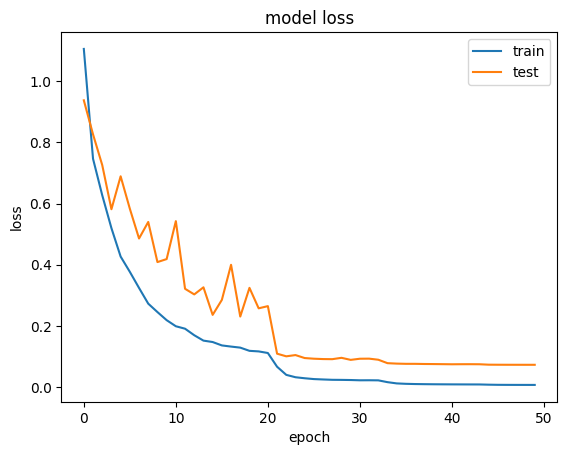

In [ ]:
plot_metric(history)

The graph shows an initial sharp and unsteady decline in loss values for both the training and testing datasets. This trend stabilizes after approximately 20 epochs. Subsequently, the loss for both training and test datasets continues to decrease gradually over time.

### Testing

In [ ]:
# Predict the most common genre (Generated by ChatGPT)
counts = balanced_df['Simplified Genre'].value_counts() / balanced_df.shape[0]
print(f"Baseline accuracy for 'Genre': {np.round(counts[0],3)}")

Baseline accuracy for 'Genre': 0.05


In [ ]:
predicted_year = balanced_df['Release Year'].mode().values[0]

# Calculate MAE for Release Year prediction (Generated by ChatGPT)
mae_baseline_year = mean_absolute_error(balanced_df['Release Year'], [predicted_year] * balanced_df.shape[0])
print(f"Baseline MAE for 'Release Year': {np.round(mae_baseline_year,3)}")

Baseline MAE for 'Release Year': 26.153


In [ ]:
# Evaluate the model
results = model.evaluate(X_test_vec, {'genre_output': y_test_genre, 'year_output': y_test_year})
print(f"Prediction Accuracy for 'Genre': {np.round(results[3], 3)}")
print(f"Mean Absolute Error for 'Release Year': {np.round(results[4],3)}")

878/878 [==============================] - 4s 4ms/step - loss: 0.0739 - genre_output_loss: 0.0210 - year_output_loss: 0.0529 - genre_output_accuracy: 0.8696 - year_output_mean_absolute_error: 0.0529
Prediction Accuracy for 'Genre': 0.87
Mean Absolute Error for 'Release Year': 0.053


The baseline model initially had a genre prediction accuracy of 5% and a mean absolute error of 26.153 for release year prediction. After implementing early stopping and reducing the learning rate on a plateau, the model completed all 50 epochs, significantly improving its performance. The final model achieved a genre prediction accuracy of 87% and a mean squared error of 0.053 for release year prediction. This performance substantially surpasses both the baseline metrics and the earlier version of the model, which had a 53.7% accuracy for genre prediction and a 0.341 mean absolute error for release year prediction.

In [ ]:
# Generated by ChatGPT

# Predictions
preds = model.predict(X_test_vec)

# Apply a threshold to determine genre presence
threshold = 0.5
genre_pred = (preds[0] > threshold).astype(int)

# True labels are already in binary format
genre_true = y_test_genre.values

# Compute confusion matrix for each genre
confusion_matrices = multilabel_confusion_matrix(genre_true, genre_pred)

878/878 [==============================] - 3s 3ms/step


In [ ]:
print(classification_report(genre_true, genre_pred, zero_division=1))

              precision    recall  f1-score   support

           0       0.97      0.89      0.93      2466
           1       0.99      1.00      0.99      1637
           2       1.00      1.00      1.00      1490
           3       0.96      0.89      0.92      3623
           4       0.97      0.98      0.98      2988
           5       1.00      1.00      1.00      1412
           6       0.98      1.00      0.99      2095
           7       0.99      0.99      0.99      1702
           8       0.98      1.00      0.99      1681
           9       1.00      1.00      1.00      1407
          10       0.97      0.92      0.94      1682
          11       0.97      0.99      0.98      1600
          12       0.99      1.00      1.00      1485
          13       0.94      0.92      0.93      1977
          14       0.97      0.98      0.98      1682
          15       1.00      1.00      1.00      1408
          16       1.00      1.00      1.00      1360
          17       0.95    

After generating a confusion matrix and a classification report, we found that the weighted average precision score is 98%, the weighted average recall score is 96%, and the weighted average f1-score is 97%

In [ ]:
# Generated by ChatGPT

# Get the genre labels
genre_labels = y_test_genre.columns

# Normalize and prepare DataFrames for each confusion matrix
cm_normalized_row_list = []
cm_normalized_col_list = []

for i, cm in enumerate(confusion_matrices):
    # Normalize by the number of instances in each true class (rows)
    cm_normalized_row = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm_df_row = pd.DataFrame(cm_normalized_row, index=['Not ' + genre_labels[i], genre_labels[i]], columns=['Not ' + genre_labels[i], genre_labels[i]])
    cm_normalized_row_list.append(cm_df_row)

    # Normalize by the number of instances in each predicted class (columns)
    cm_normalized_col = cm.astype('float') / cm.sum(axis=0)[np.newaxis, :]
    cm_df_col = pd.DataFrame(cm_normalized_col, index=['Not ' + genre_labels[i], genre_labels[i]], columns=['Not ' + genre_labels[i], genre_labels[i]])
    cm_normalized_col_list.append(cm_df_col)

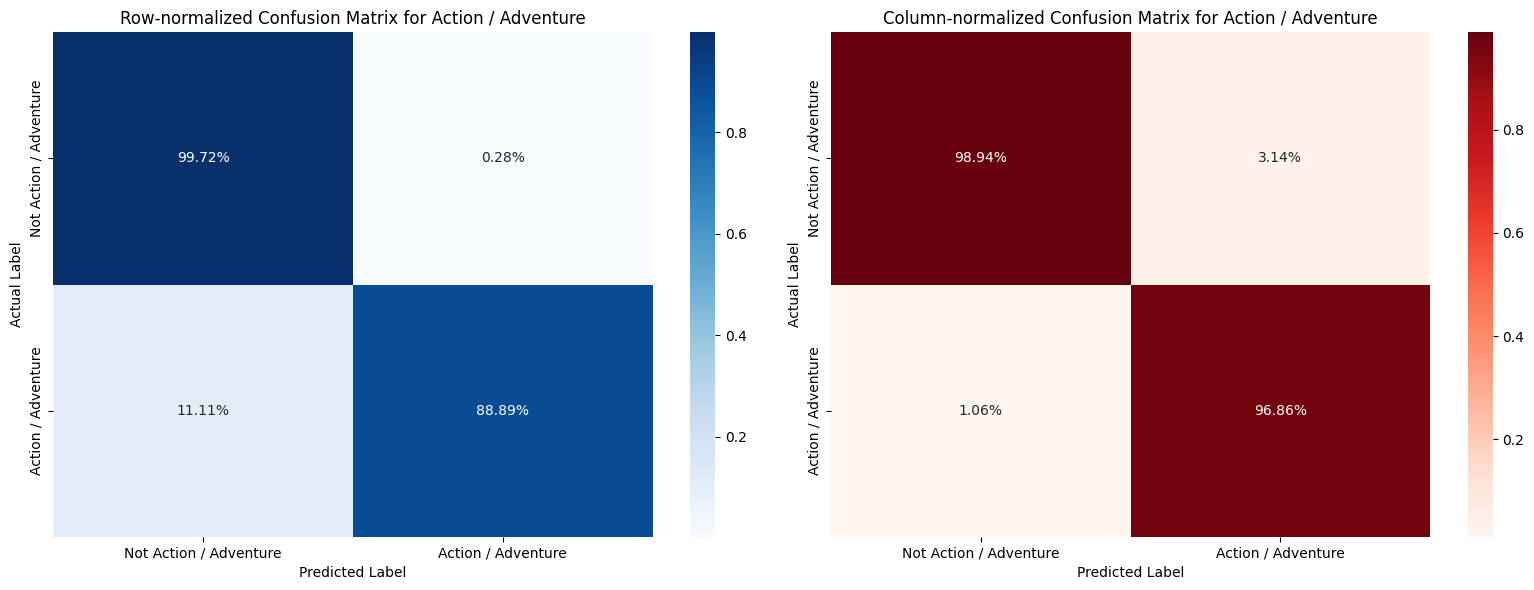

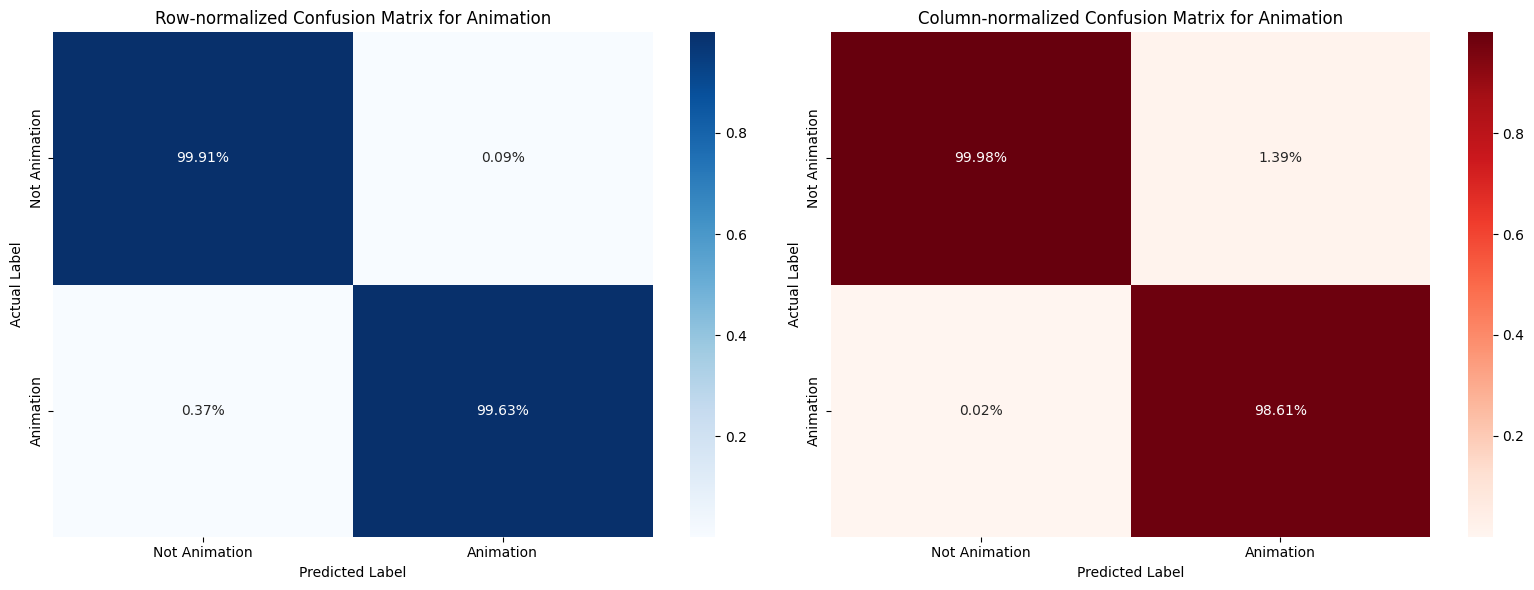

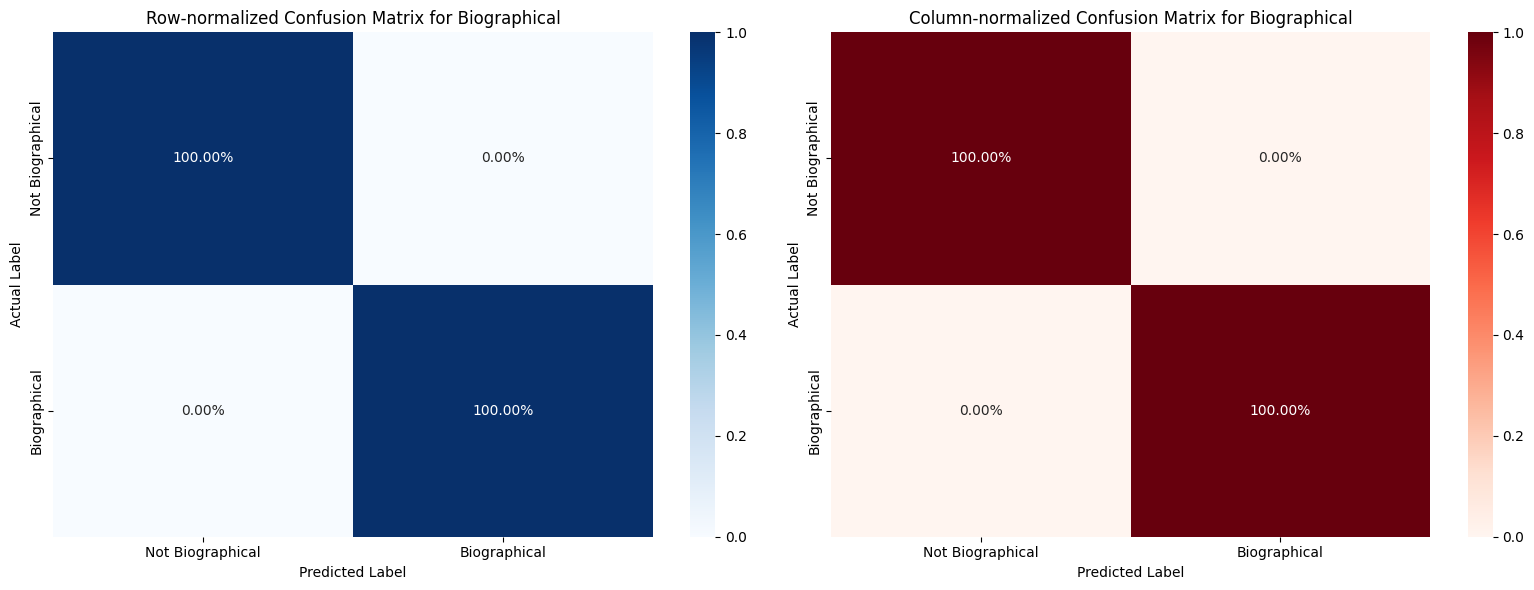

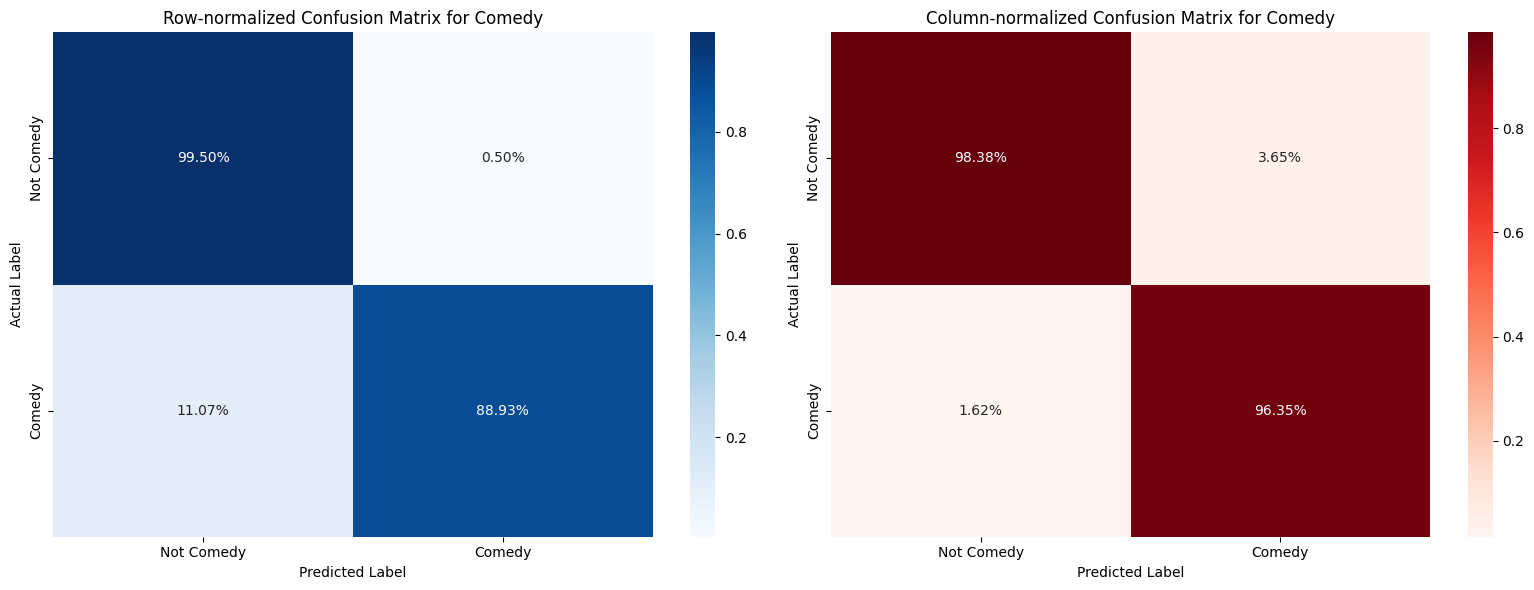

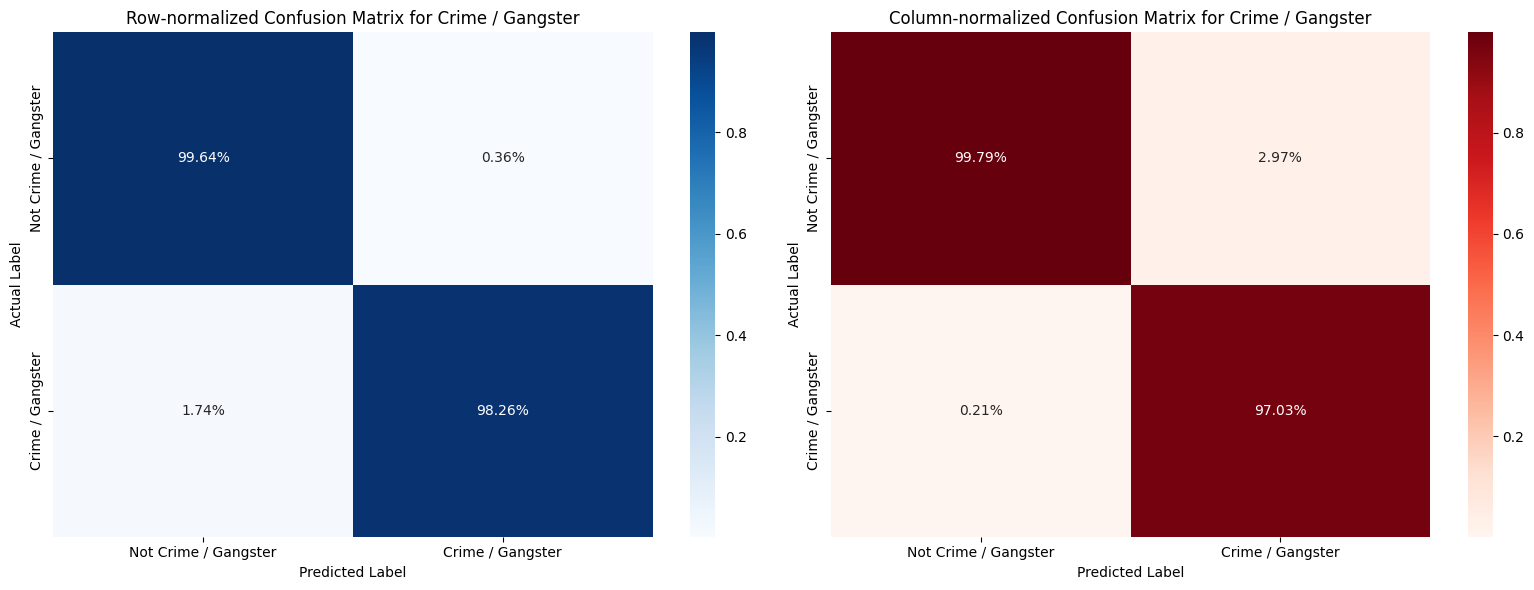

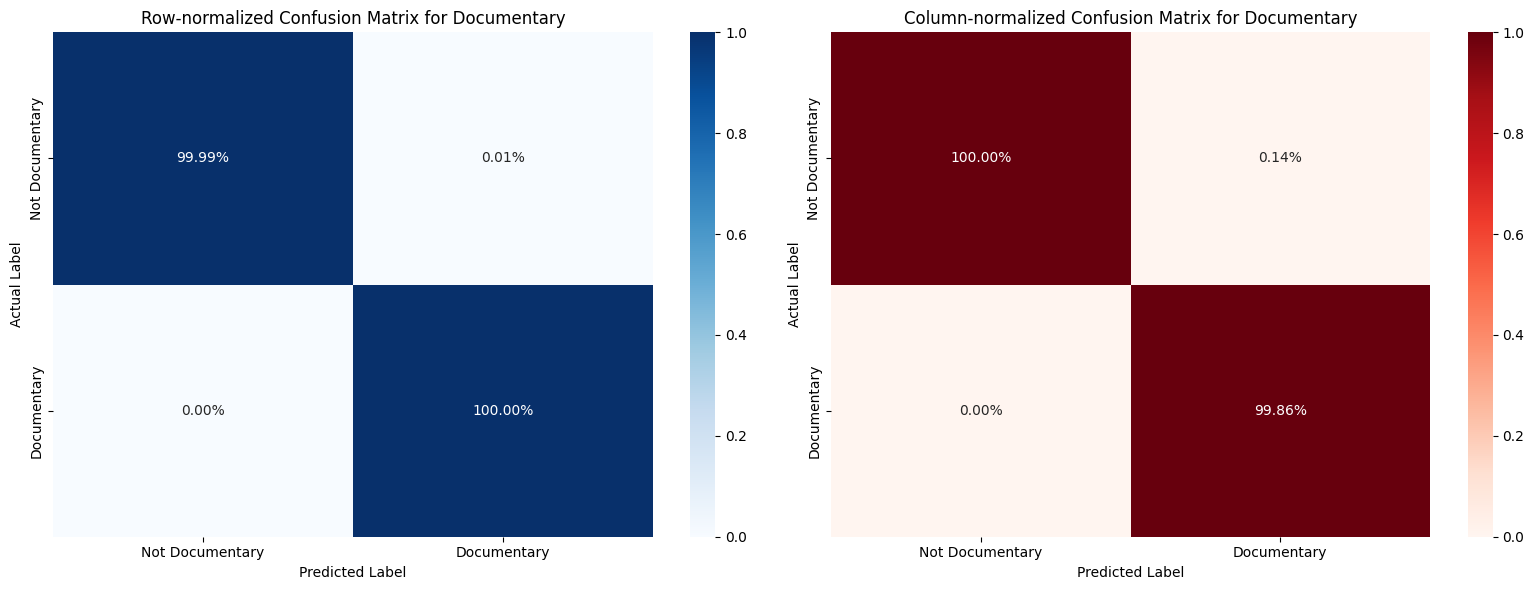

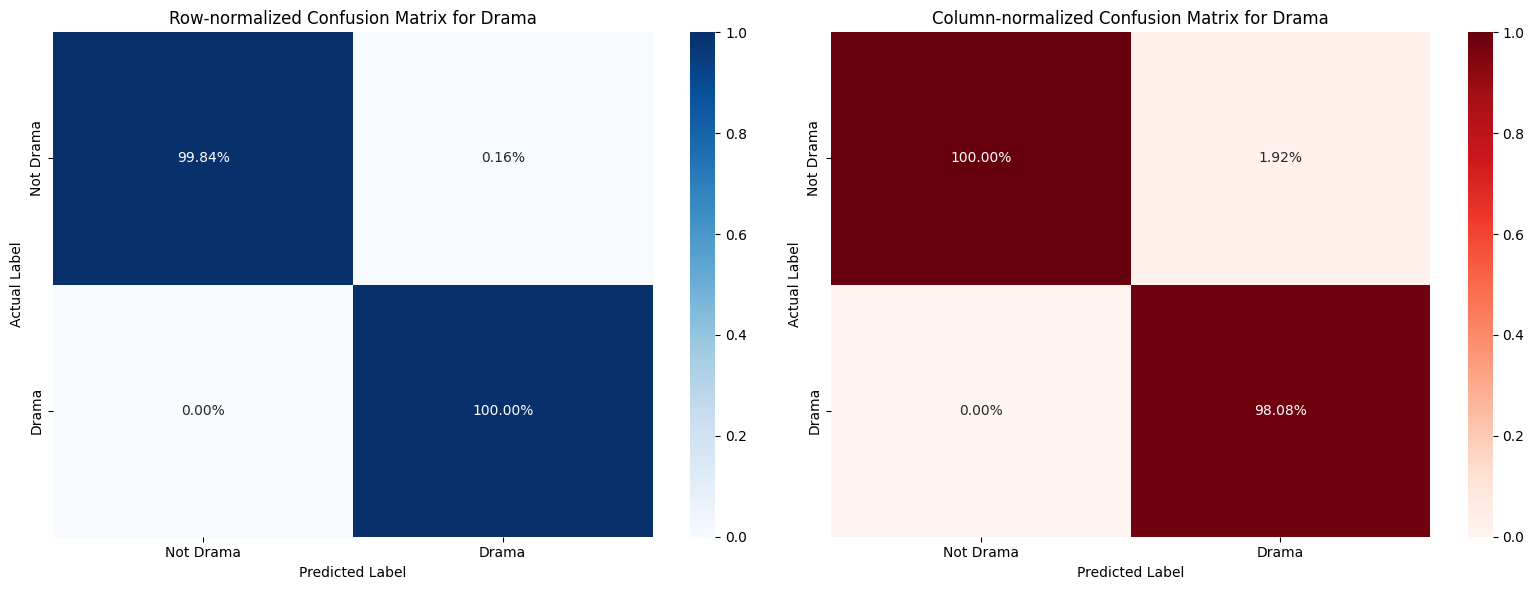

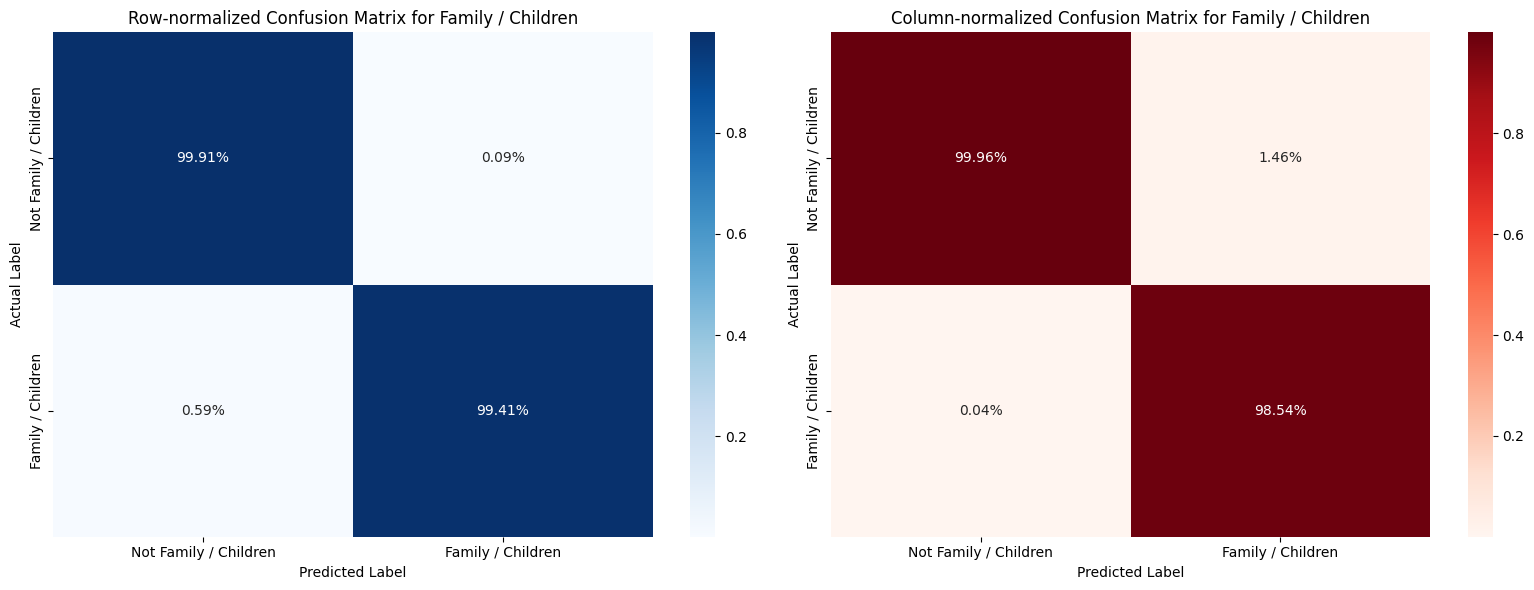

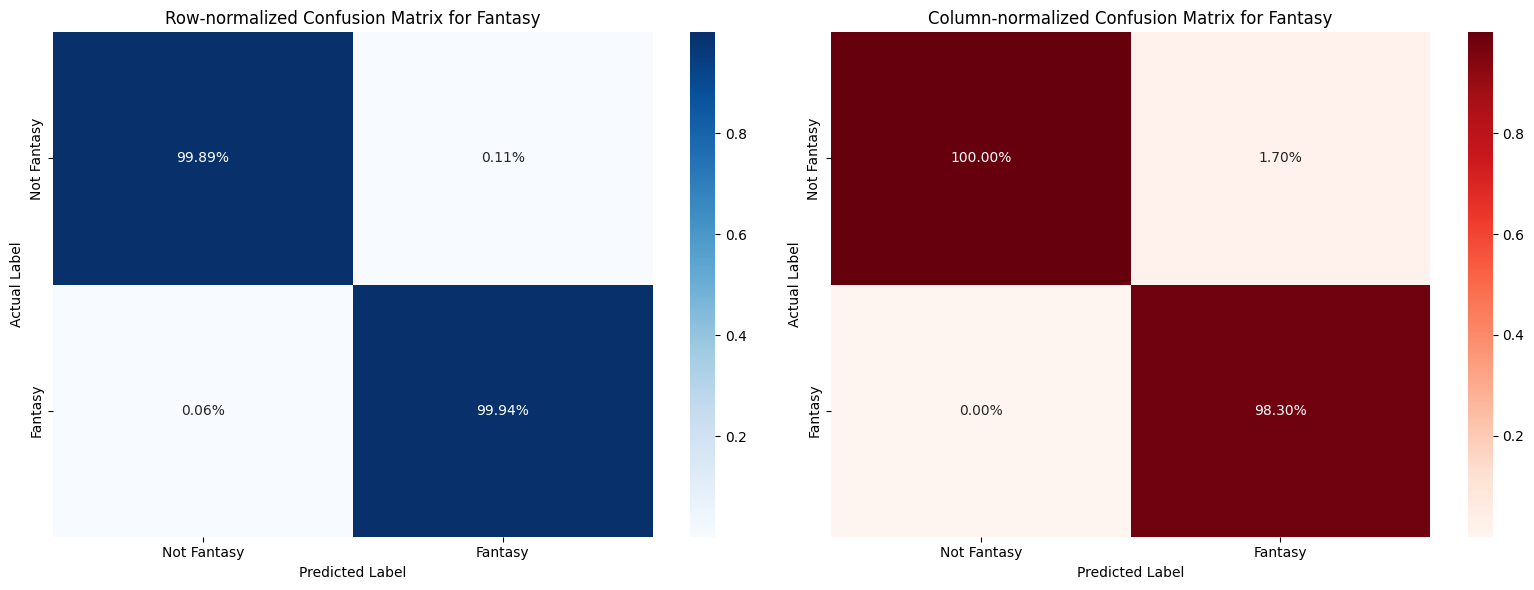

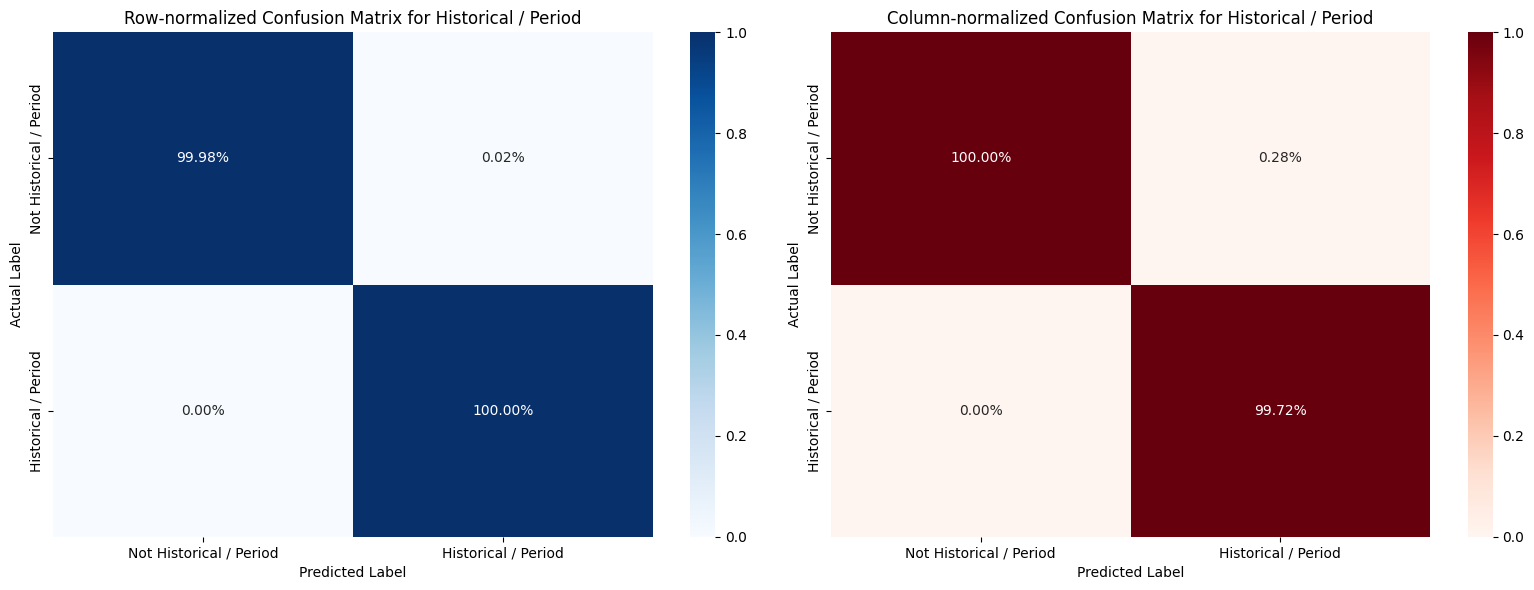

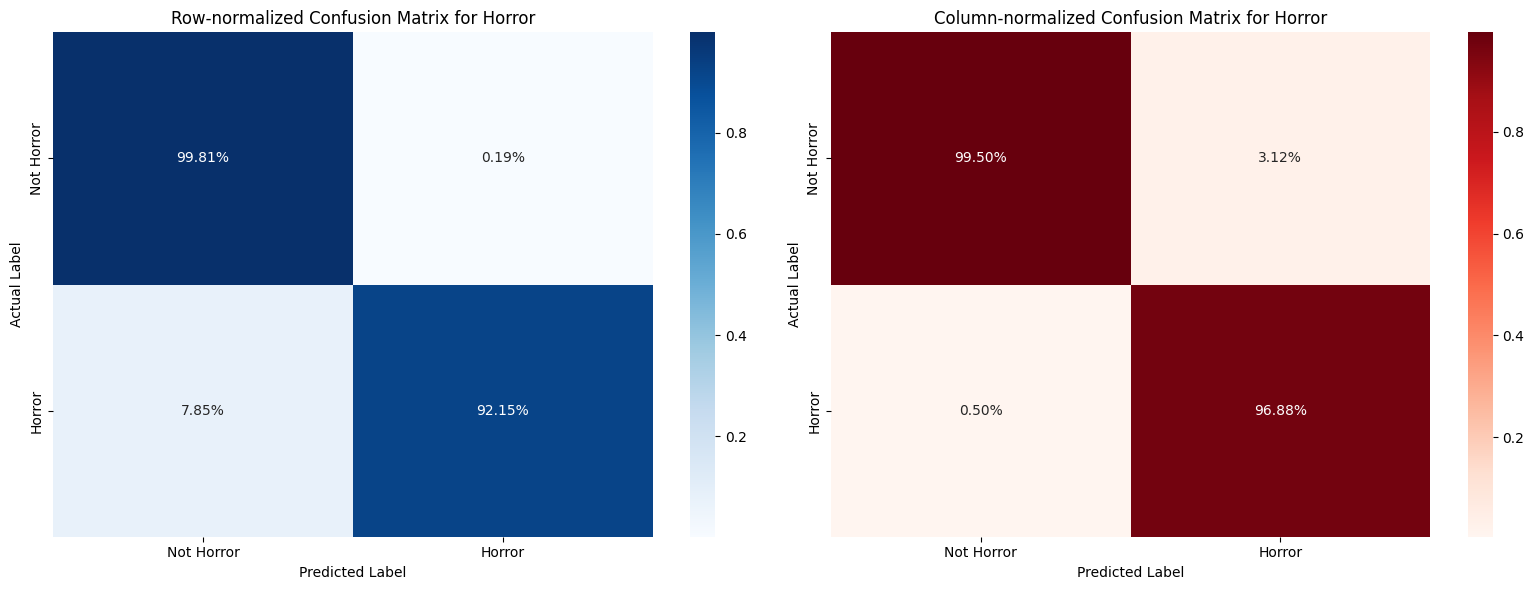

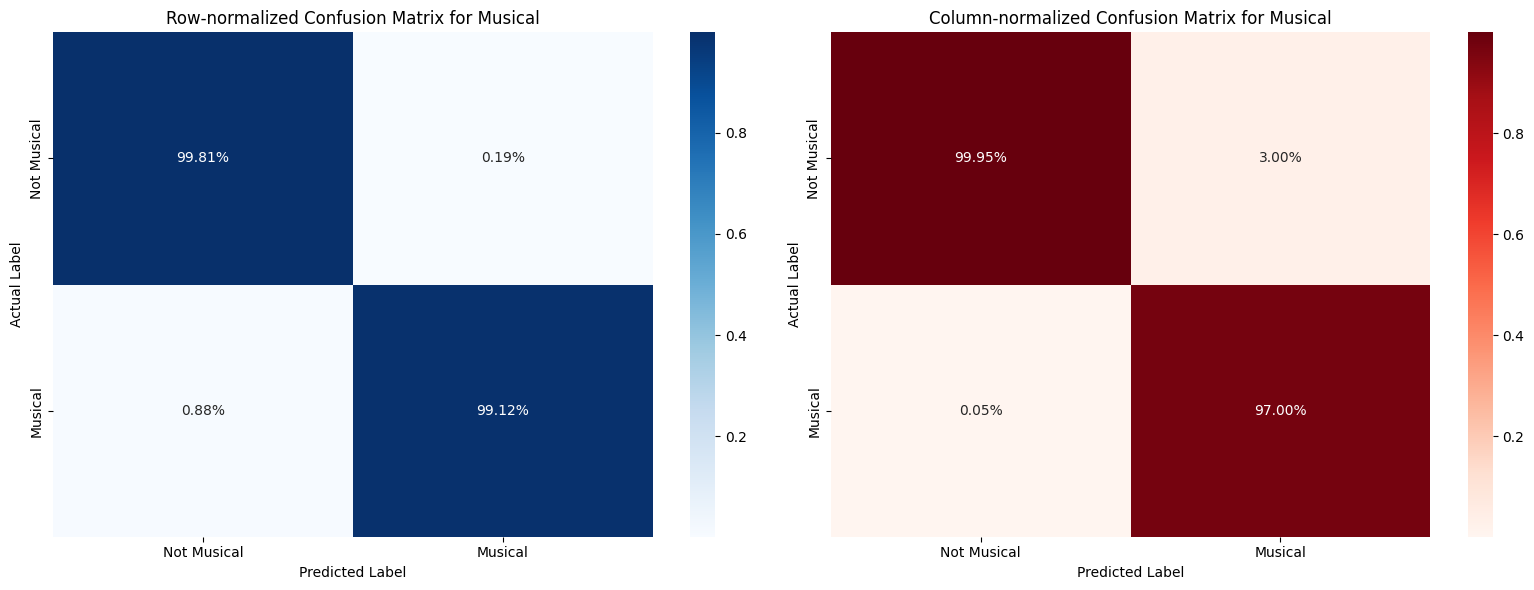

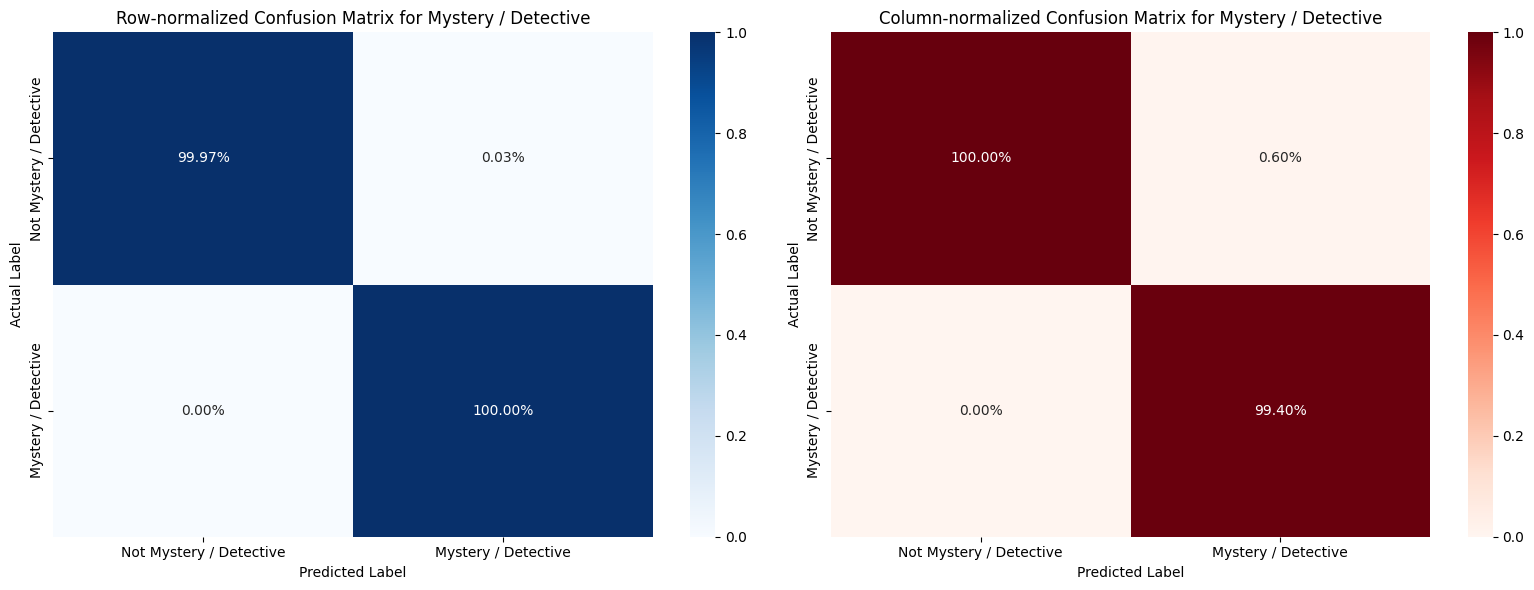

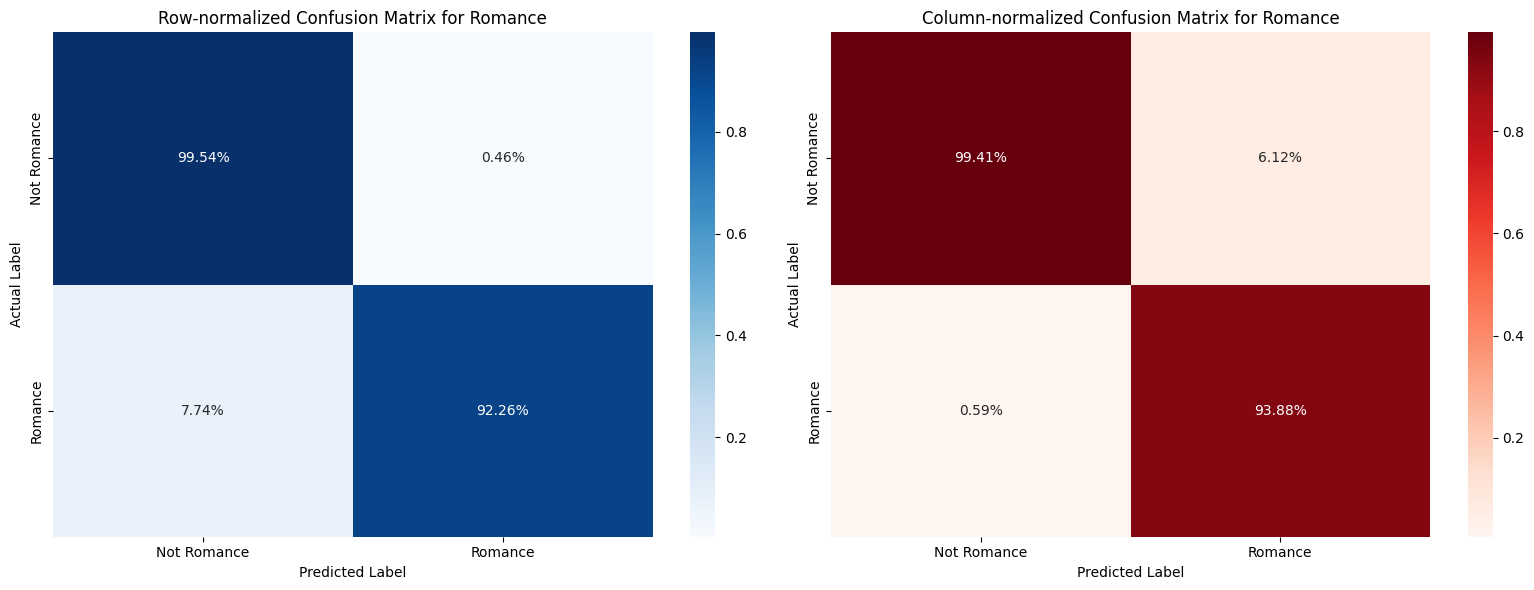

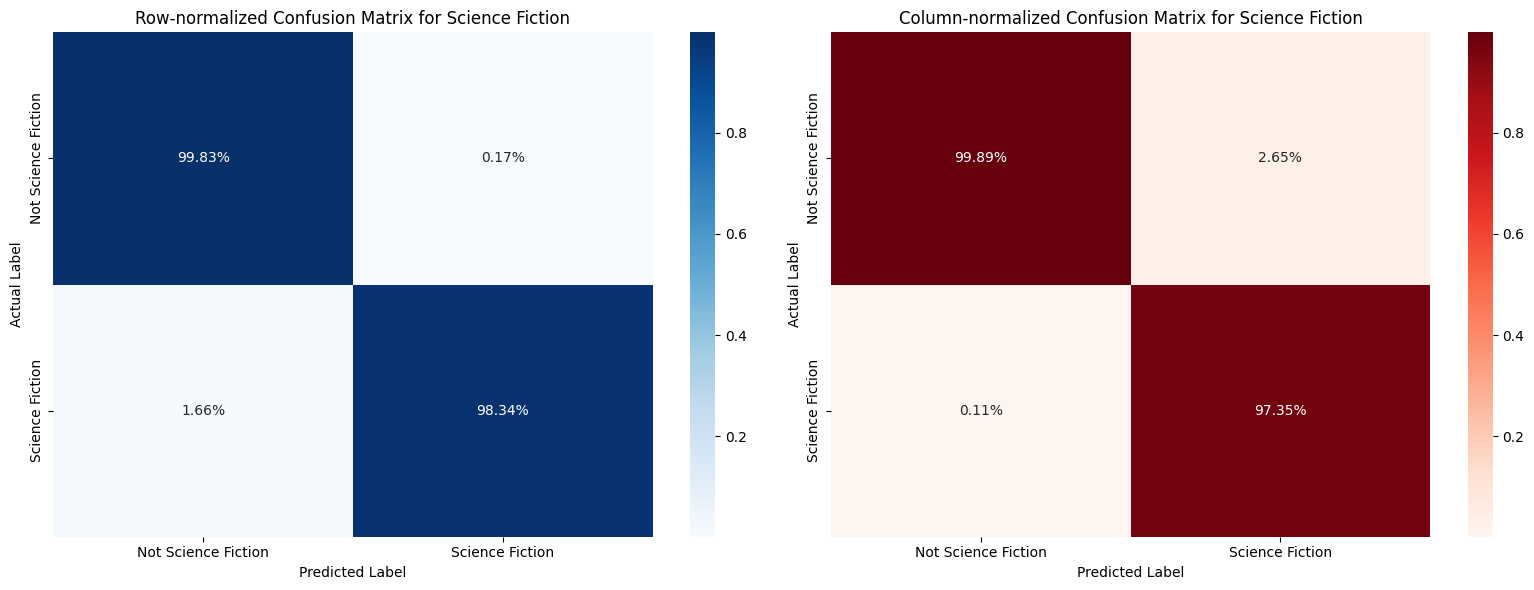

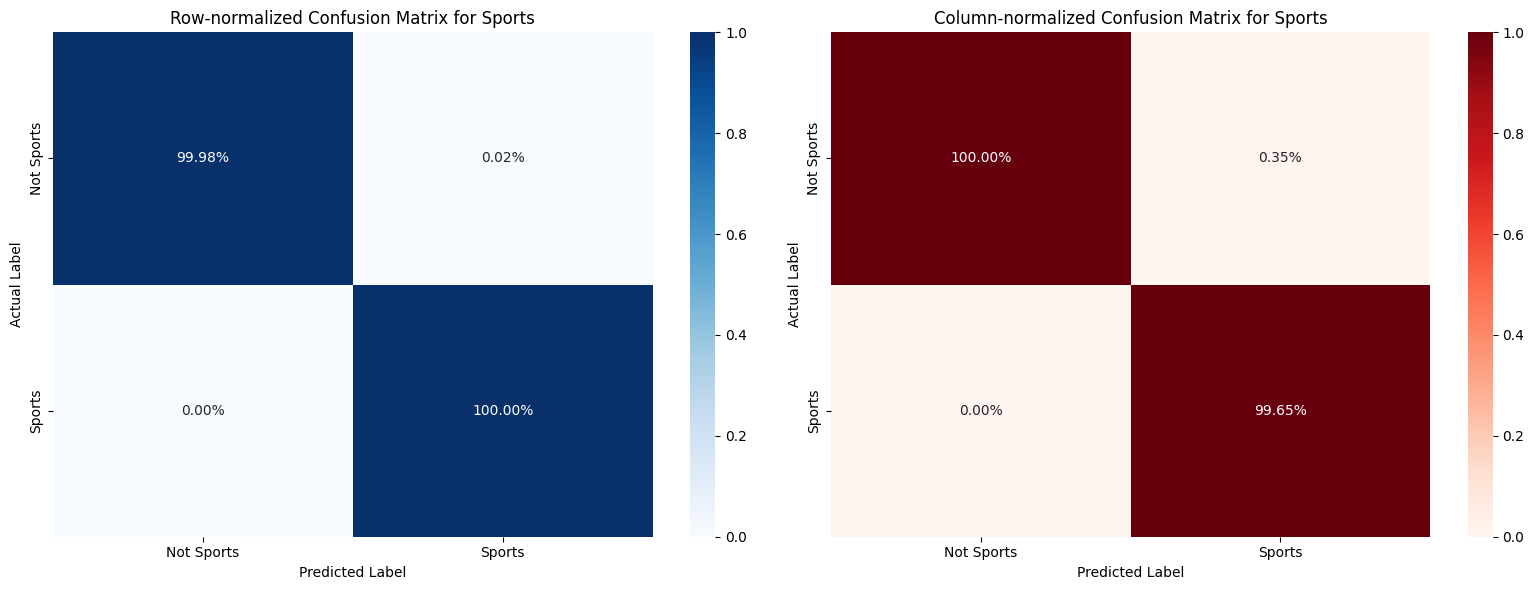

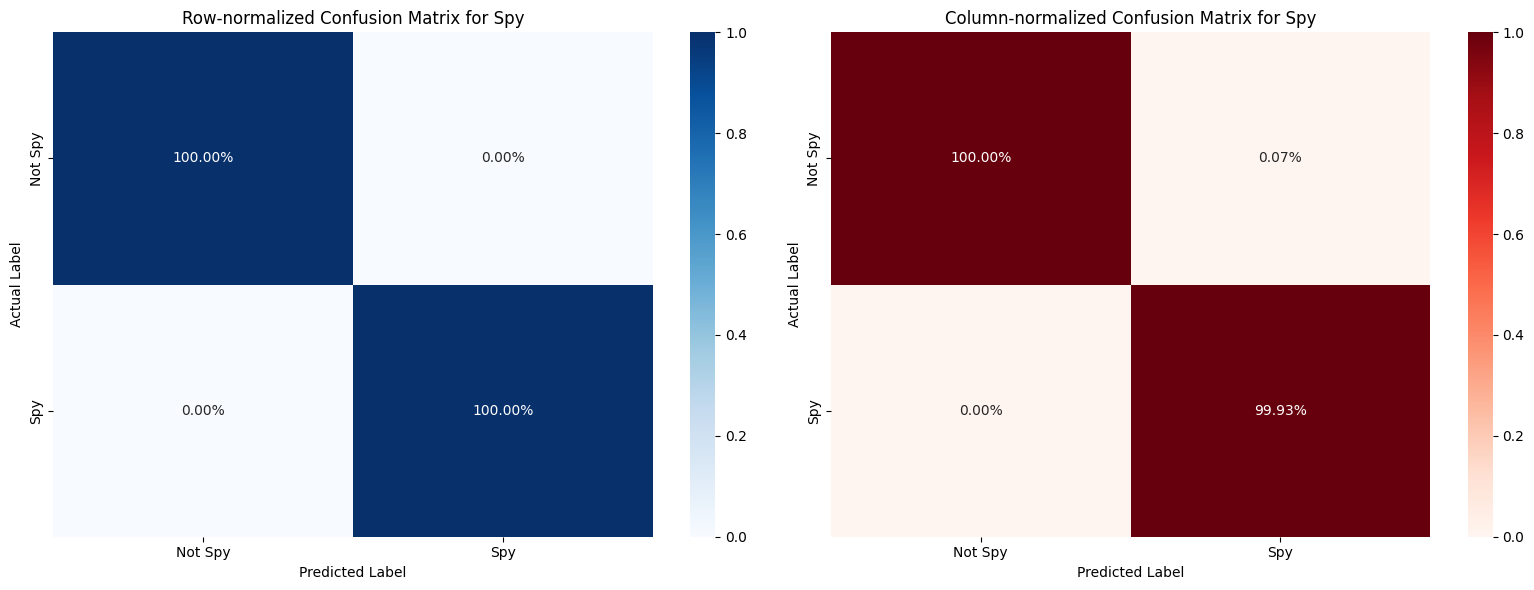

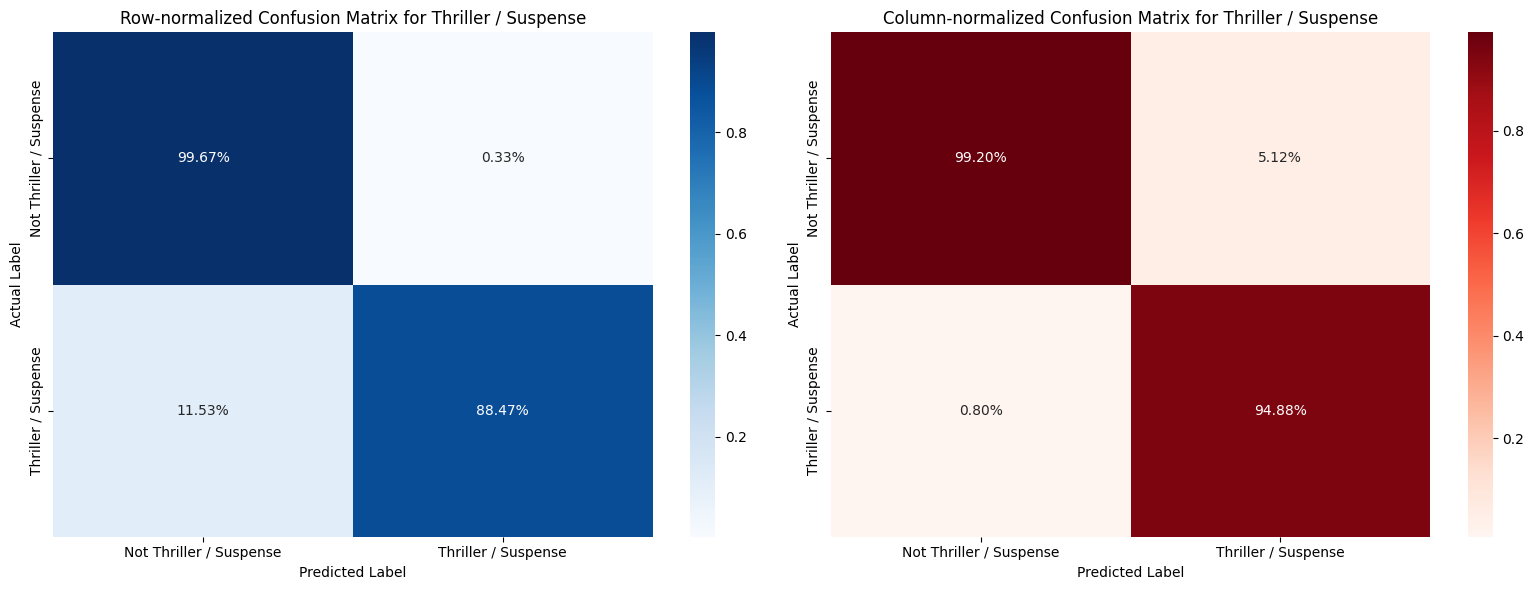

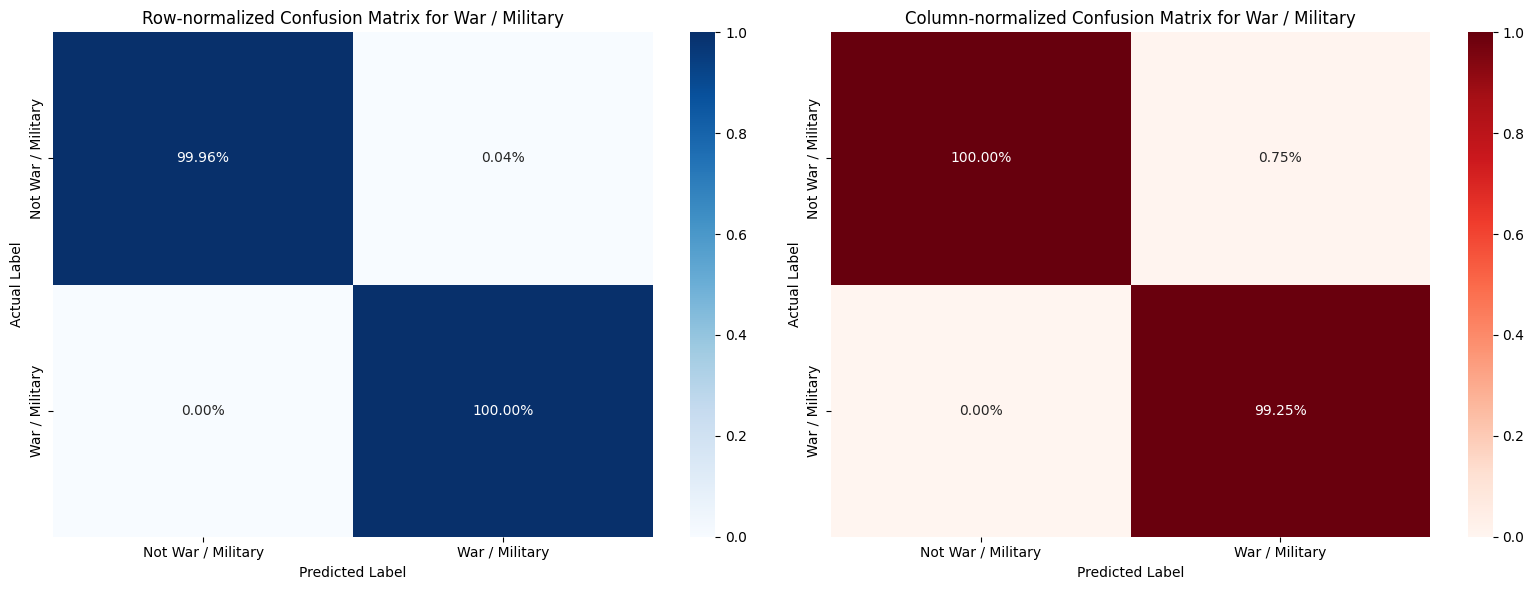

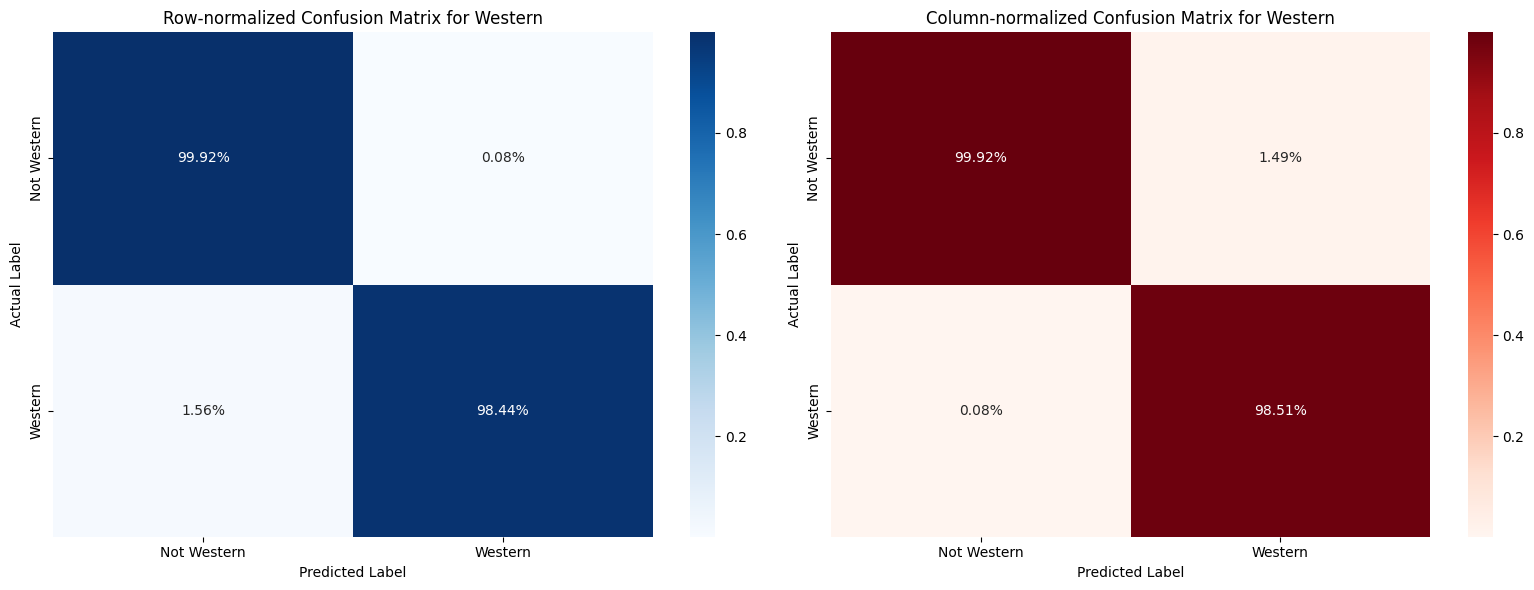

In [ ]:
# Generated by ChatGPT

# Loop to plot confusion matrices
for i in range(len(cm_normalized_col_list)):
    # Create subplots: 1 row, 2 columns
    fig, ax = plt.subplots(1, 2, figsize=(16, 6))  # Adjust the size as needed

    # Plot row-normalized confusion matrix
    sns.heatmap(cm_normalized_row_list[i], annot=True, fmt=".2%", cmap='Blues', ax=ax[0])
    ax[0].set_title(f'Row-normalized Confusion Matrix for {genre_labels[i]}')
    ax[0].set_ylabel('Actual Label')
    ax[0].set_xlabel('Predicted Label')
    ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=0)

    # Plot column-normalized confusion matrix
    sns.heatmap(cm_normalized_col_list[i], annot=True, fmt=".2%", cmap='Reds', ax=ax[1])
    ax[1].set_title(f'Column-normalized Confusion Matrix for {genre_labels[i]}')
    ax[1].set_ylabel('Actual Label')
    ax[1].set_xlabel('Predicted Label')
    ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=0)

    # Display the plot
    plt.tight_layout();

After visualizing the confusion matrices for all genres, we observe that the model consistently performs well, with a limited rate of misclassification across the various movie genres.

### Conclusions

In this project, we have successfully developed and evaluated a machine learning model that utilizes plot summaries to predict the genre and release year of movies. This endeavor, grounded in data science and analytics, demonstrates the efficacy of applying advanced machine learning techniques to the domain of movie analytics.

The foundational step of our project involved a thorough analysis of the Wikipedia Movie Plots dataset. This process was critical in understanding the data's characteristics and informing our strategy for preprocessing. Key decisions, such as focusing on movies released after 1940 and categorizing genres into more generalized groups, were made to optimize the model's learning capability and to address data imbalance.

The core of our project was the development of a machine learning model using a Transformer encoder. This choice of architecture was instrumental in capturing the complex patterns in plot summaries. The integration of GloVe embeddings further enhanced the model's ability to interpret and process natural language semantics, a crucial aspect of understanding plot narratives.

Hyperparameter tuning was approached with precision and analytical rigor. Through a series of grid searches, we identified the optimal set of parameters that improved the model's accuracy and generalizability. This step was not only vital for enhancing model performance but also provided valuable insights into the model's dynamics and the influence of various parameters.

The evaluation phase was conducted with a focus on objectivity and accuracy. The use of metrics such as genre prediction accuracy and mean absolute error for release year prediction allowed us to quantitatively assess the model's performance. Additionally, the employment of confusion matrices and classification reports provided a detailed view of the model's predictive capabilities across different genres.

Finally, the visualization of the project's findings was executed with a focus on clarity and precision, ensuring that the results were presented in an understandable and informative manner. These visualizations were not only critical for interpreting the model's performance but also served as a tool for communicating the findings of our work.

The main challenges that were presented were figuring out how to preprocess the data for good model performance. Given that the data set's genre column had 2265 unique genres, it was a string, and some movies contained more than one genre, we had to figure out how to salvage as much data as possible, while also making the problem managable by recategorizing the genres into a list, and limiting the number of unique genres in the data set. Another challenge we faced was balancing the data set. As seen in the data exporation section, the data set was heavily skewed towards three genres, where the most common genre was unknown.

In summary, this project stands as a testament to the potential of natural language processing in machine learning and in transforming our understanding and analysis of cinematic content.